In [110]:
import os
from combine_results import find_files
from eval_model import get_model_structure
import numpy as np
from utils import load_names, load_observed
from plot_utils_bpaitac import histogram
from region_identification_utils import get_trial_metrics, identify_regions, summary_stats
import pandas as pd
from load_model import get_model, get_predictions, load_model
import scipy
import matplotlib.pyplot as plt


Model specific information setup \
model1 is the baseline model- the point of comparison. I.E. $\lambda = 0$\
model2 is the experimental model

In [111]:
# For BP71
# model1_dir = '/data/nchand/analysis/BPnetRep/BP71_L0_0/'
# model2_dir = '/data/nchand/analysis/BPnetRep/BP71_L-1_1/'
# output_dir = '/data/nchand/analysis/BPnetRep/BP71_analysis'
# label1='l=0.0'
# label2='l=0.1'
# model_type = 'BPnetRep'
# n_trials_to_use = 3 # TODO update when I have more


In [112]:
# For BP203
model1_dir = '/data/nchand/analysis/BPcm_250/BP200_L0_0/'
model2_dir = '/data/nchand/analysis/BPcm_250/BP203_no_seed_L-1_5/'
output_dir = '/data/nchand/analysis/BPcm_250/BP203_200_analysis'
model_type = 'BPcm_250'

lineage_filepath = 'immgen_lineages.csv' # insert path to file here
difference_label ='Difference in Pearson correlation at lambda=0.5 and lambda=0.0'
n_trials_to_use = 5
label1='l=0.0'
label2='l=0.5'


General setup - applicable to most models

In [113]:
n_celltypes = 90
n_filters = 300
bin_size= 1
bin_pooling_type = None
scalar_head_fc_layers = 1

eval_set = 'test'
info_path = '/data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/info.txt'

peak_names = load_names('/data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/info.txt', eval_set)
cell_names = np.load("/data/nchand/ImmGen/mouse/BPprofiles1000/ImmGenATAC1219.peak_matched_in_sorted.sl10004sh-4.celltypes.npy")


analysis_file_name = 'testing_analysis.npz'
model_structure = get_model_structure(model_type, n_filters, n_celltypes)
new_analysis = True
os.makedirs(output_dir, exist_ok=True)

file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.names.dat
shape (32361,)
199
39
7


Find the regions which are better predicted in model 2 than model 1

model1_dir the parent directory of all the trials of model 1
    this dir will contain an 'analysis_' + eval_set + '_trials.npz' file
    If it does not already contain one, one will be created
model2_dir the parent directory of all the trials of model 2
    this dir will contain an 'analysis_' + eval_set + '_trials.npz' file 

In [114]:
import torch 
def get_pred(model, region_onehot, region_bias):
    device = next(model.parameters()).device
    X = torch.from_numpy(np.expand_dims(region_onehot, axis=0))
    bias = torch.from_numpy(region_bias)
    model.eval()
    print('X shape', X.size())
    print('bias shape in get pred', bias.size())
    with torch.no_grad():
        profile, scalar = model(X.to(device), bias.to(device))
    return torch.squeeze(profile).cpu().numpy(), np.squeeze(torch.squeeze(scalar).cpu().numpy()) 

In [115]:
get_trial_metrics_eval_set = eval_set
if eval_set == 'test':
        get_trial_metrics_eval_set = 'testing'

model1_metrics = get_trial_metrics(model1_dir, info_path, n_celltypes, n_filters, bin_size, bin_pooling_type,
                        scalar_head_fc_layers, 
                        get_trial_metrics_eval_set,
                        new_analysis,
                        analysis_file_name,
                        model_structure=model_structure,
                        )
model2_metrics = get_trial_metrics(model2_dir, info_path, n_celltypes, n_filters, bin_size, bin_pooling_type,
                        scalar_head_fc_layers, 
                        get_trial_metrics_eval_set,
                        new_analysis,
                        analysis_file_name,
                        model_structure=model_structure,
                        )
model1_corr, model2_corr = model1_metrics['scalar_corr'], model2_metrics['scalar_corr']
if n_trials_to_use is not None:
        model1_corr, model2_corr = model1_corr[:,:n_trials_to_use], model2_corr[:,:n_trials_to_use]
        print('new shape of corr1 and 2', model1_corr.shape, model2_corr.shape)

idx_higher_in_model2 = identify_regions(model1_corr, model2_corr)

['/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.15.03/best_model', '/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.15.04/best_model', '/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.15.05/best_model', '/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.22.30/best_model', '/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-09-2025.04.28/best_model', '/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-01-2025.07.59/best_model']
Analysis file name is testing_analysis.npz
using existing /data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.15.03/testing_analysis.npz


(32361, 0)
shape metrics[metric] [ 0.31630886 -0.12042658  0.11269398 ...  0.03450864  0.3379192
  0.2163238 ]
(32361, 90, 0)
shape metrics[metric] [[ 0.10037393  0.27341634 -0.00757166 ...  0.1403045   0.03844888
  -0.02333194]
 [ 0.09303889  0.09552735  0.12779716 ...  0.05228642  0.12534955
   0.19958097]
 [-0.01302434  0.07945814  0.22448704 ...  0.          0.
   0.        ]
 ...
 [-0.00343837 -0.03318547  0.         ...  0.01062778 -0.01023738
   0.40644234]
 [ 0.00237827 -0.03675774 -0.03006725 ... -0.01438336 -0.00664247
   0.        ]
 [-0.02926533 -0.0273773  -0.0569834  ... -0.02169927 -0.04741234
  -0.00502426]]
(32361, 90, 0)
shape metrics[metric] [[0.8510643  0.7469851  0.9135836  ... 0.80362535 0.92411596 0.96694577]
 [0.73576725 0.7495571  0.77880716 ... 0.8805134  0.8479198  0.81496406]
 [0.9839674  0.85873723 0.7599131  ... 0.55817026 0.540421   0.71815145]
 ...
 [0.9856913  0.99804044 0.60942614 ... 0.95352805 0.9744483  0.73372805]
 [0.9091183  0.9907226  0.99736404

Number of regions: 4047
Fraction of regions with increase 0.1250579401130991
(32361,)
Mean difference 0.12082812909771981
Mean difference in improved regions 0.3689675180020659


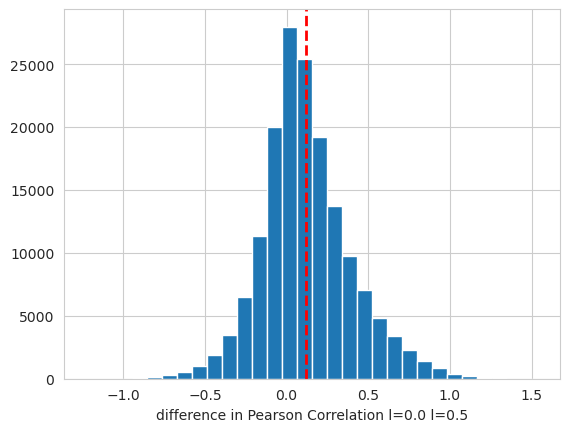

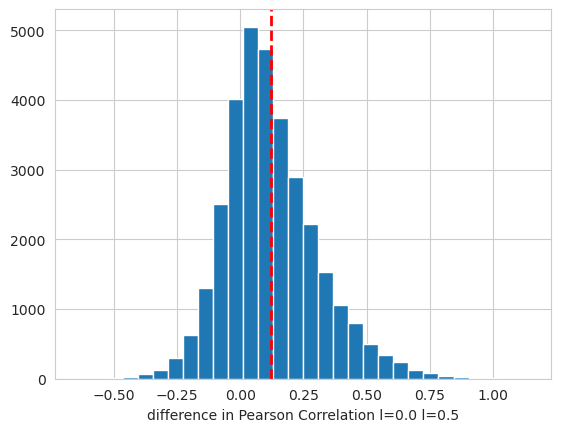

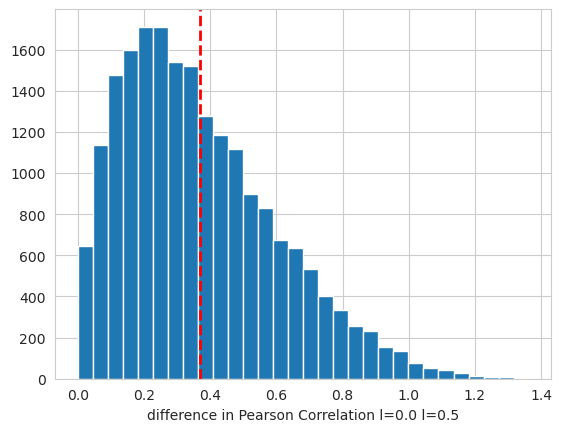

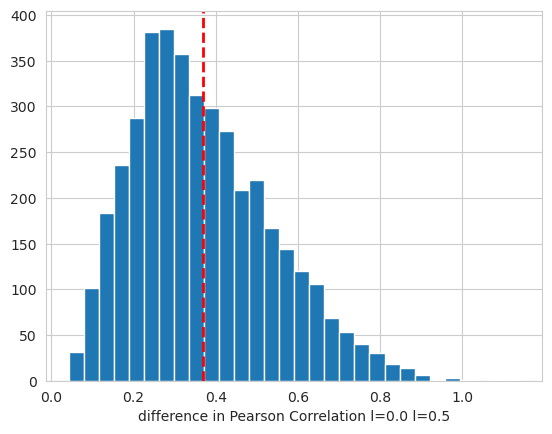

In [116]:
summary_stats(model1_corr, model2_corr, 
                idx_higher_in_model2, output_dir, metric_name='Pearson Correlation', label1=label1, label2=label2)


In [117]:
def group_celltypes(cell_names):
    # Load the data from the Excel file
    df = pd.read_excel('/data/nchand/ImmGen/mouse/1-s2.0-S0092867418316507-mmc1.xlsx')
    # Create the dictionary
    lineage_to_celltype = {}

    # Iterate through the DataFrame and build the dictionary
    for _, row in df.iterrows():
        lineage = row['Lineage']
        celltype = row['CellType']
        
        if lineage not in lineage_to_celltype:
            lineage_to_celltype[lineage] = []
        lineage_to_celltype[lineage].append(celltype)


    lineages = {key: [] for key in lineage_to_celltype}
    lineage_indices = {key: [] for key in lineage_to_celltype}

    for i, name in enumerate(cell_names):
        for lineage, cells in lineage_to_celltype.items():
            if any(name.startswith(cell) for cell in cells):
                lineages[lineage].append(name)
                lineage_indices[lineage].append(i)
                break
        else:
            print(f"Unrecognized cell subtype: {name}")

    return lineages, lineage_indices

In [118]:
def get_cellgroup_avg(celltype_indices, data):
    # Converts data of shape n_regions x celltypes -> n_regions x n_celltype_groups
    # by averaging across celltypes in the same group
    # celltype_indices maps celltype group names to the indices of cell subtypes associated with that group
    n_regions, n_subtypes = data.shape
    n_groups = len(celltype_indices)
    print(n_regions, n_subtypes, n_groups)
    # group_names = {}
    # for group, indices in celltype_indices.items():
    #     group_names.append(group)
    #     cell_type_data = [cell_data[i] for i in indices]
    #     cell_type_averages[cell_type] = sum(cell_type_data) / len(cell_type_data)


In [119]:
celltype_groups, celltype_indices = group_celltypes(cell_names=cell_names)
celltype_indices.items()


Unrecognized cell subtype: MF.SI.LP
Unrecognized cell subtype: MMP3.48+.BM
Unrecognized cell subtype: MMP4.135+.BM
Unrecognized cell subtype: T8.IEL.LCMV.d7.Gut


dict_items([('Stem&Prog', [32, 33, 57]), ('B', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 82, 87, 88, 89]), ('abT', [53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 80, 81, 83, 84, 85, 86]), ('T.act', [60, 68, 69, 70, 71, 72]), ('gdT', [73, 74, 75, 76, 77, 78, 79]), ('ILC', [27, 28, 29, 30, 47, 48, 49, 50, 51, 52]), ('myeloid', [23, 24, 25, 34, 35, 36, 37, 38, 39, 41, 42]), ('monocyte', [45, 46]), ('DC', [16, 17, 18, 19, 20]), ('stroma', [15, 21, 22, 26, 31])])

$p_L(x)$ is the pearson correlation of region x for model trained with lambda=L

Region selection:
1. $p_L(x) > p_0(x)$ for all trials              | already found by idx_higher_in_model2 
2.  $avg\{ p_L(x) \} - avg\{p_0(x)\} > 0.45$  | large difference  - can probably cut
3.  $avg\{ p_L(x) \} > 0.85$                  | good predictions - go down to 0.7 (like in AI-TAC)
4.  $std_{celltypes}(TC_{obs}(x)) > mean(std_{celltypes}(TC_{obs}(x)))$               | standard deviation: differential expressions in celltypes - people like coefficience of variance: variance / mean or median. Gini index can also be tried 

Find idx of regions that meet the above criteria, and take the intersection of them

V2 of region identification criteria

$p_L(x)$ is the pearson correlation of region x for model trained with lambda=L
TC(x) is the total number of Tn5 cuts for region x

Region selection:
1. $p_L(x) > p_0(x)$ for all trials              | correlation is better in model with nonzero lambda (already found by idx_higher_in_model2)
2.  $avg\{ p_L(x) \} > 0.5$                  | good predictions- above 0.5 pearson correlation
3.  $std_{celltypes}(TC_{obs}(x))/{mean(TC_{obs})} > 1.2$               | coefficient of variance: variance of total counts among celltypes is higher than 1.2
4. $max(TC_{obs}(x)) > 150$


V3 of region identification criteria

$p_L(x)$ is the pearson correlation of region x for model trained with lambda=L
TC(x) is the total number of Tn5 cuts for region x

Region selection:
1. $p_L(x) > p_0(x)$ for all trials              | correlation is better in model with nonzero lambda (already found by idx_higher_in_model2)
2.  $avg\{ p_L(x) \} > 0.5$                  | good predictions- above 0.5 pearson correlation
3.  $std_{celltypes}(TC_{obs}(x))/{mean(TC_{obs})} > 1$               | coefficient of variance: variance of total counts among celltypes is higher than 1
4. $max(TC_{obs}(x)) > 150$


In [120]:
# find avg\{ p_L(x) \} - avg\{p_0(x)\} > 0.45
def get_regions_with_large_difference(avg_model1_corr, avg_model2_corr):
    # get average pearson correlation across trials
    idx_large_difference = np.where(avg_model2_corr - avg_model1_corr > 0.45)[0]
    print(idx_large_difference.shape[0], 'regions meet critera of large difference between model1 and model2 accuracy')
    return idx_large_difference

In [121]:
def get_regions_with_good_predictions(avg_model2_corr, threshold=0.85):
    # avg\{ p_L(x) \} > 0.85 good predictions
    idx_good_prediction = np.where(avg_model2_corr > threshold)[0]
    print(idx_good_prediction.shape[0], 'regions meet criteria of good prediction for model2')
    return idx_good_prediction

In [122]:
# Find regions with good standard dev in total counts across celltypes\
# We set the threshold of included regions to be ones with a standard devation across celltypes to be greater than the mean SD 
def get_regions_with_good_std_dev_in_celltypes(info_path, eval_set):
    # get standard deviation of observed total counts
    obs_total_counts = load_observed(info_path, eval_set, 'total_counts')
    tc_sd = np.std(obs_total_counts, axis=1)
    # histogram(tc_sd.flatten(), 'standard deviation of total counts across celltypes', '', format='png', save_fig=False)
    tc_sd_mean = np.mean(tc_sd)
    print('Standard deviation mean', tc_sd_mean)
    idx_variance = np.where(tc_sd > tc_sd_mean)[0]
    print(idx_variance.shape, 'regions meet criteria of higher than avg variance between celltypes')
    return idx_variance


In [123]:
from scipy.stats import gaussian_kde

# Find regions with good coefficient in total counts across celltypes\
# We set the threshold of included regions to be ones with a coefficient of variance across celltypes to be greater than the mean coefficient of variance 
def get_regions_with_good_variance_in_celltypes(info_path, eval_set, threshold=None):
    # get observed total counts
    obs_total_counts = load_observed(info_path, eval_set, 'total_counts')
    cv = np.std(obs_total_counts, axis=1) / np.mean(obs_total_counts, axis=1)
    cv_mean = np.mean(cv)
    # histogram(cv.flatten(), 'coef of variance of total counts across celltypes', '', format='png', save_fig=False)
    max_tc = np.max(obs_total_counts, axis=1)
    print('shape max tc', max_tc.shape)
    print('Mean coefficient of variation:', cv_mean)
    if threshold is None:
        idx_variance = np.where(cv > cv_mean)[0]
    else:
        idx_variance = np.where(cv > threshold)[0]
    print(f'{idx_variance.shape[0]} regions meet criteria of coefficient of variation between celltypes')

    # xy = np.vstack([cv.flatten(), max_tc])
    # z = gaussian_kde(xy)(xy)
    
    # plt.figure(figsize=(10, 8))
    # plt.scatter(cv.flatten(), max_tc, c=z, s=10, cmap='viridis')
    # plt.colorbar(label='Density')
    # plt.xlabel('Coefficient of Variance')
    # plt.ylabel('Max Total Count Across Celltypes')
    # plt.title('Density Scatter Plot of Coefficient of Variance vs Max Total Count')
    # plt.show()
    return idx_variance

In [124]:
def get_regions_with_sufficient_total_counts(info_path, eval_set, threshold):
    obs_total_counts = load_observed(info_path, eval_set, 'total_counts')
    max_tc = np.max(obs_total_counts, axis=1)
    print('mean max tc', np.mean(max_tc))
    # histogram(max_tc, "max total counts", '', save_fig=False)
    idx = np.where(max_tc > threshold)[0]

    print(f'{idx.shape[0]} regions meet criterion of sufficient total counts more than {threshold}')
    return idx


In [125]:
get_regions_with_sufficient_total_counts(info_path=info_path, eval_set=eval_set, threshold=100)


file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
mean max tc 174.04488
19102 regions meet criterion of sufficient total counts more than 100


array([    7,     9,    11, ..., 32356, 32359, 32360])

In [126]:
# NOTE This is duplicated in a method below!
get_regions_with_good_variance_in_celltypes(info_path=info_path, eval_set=eval_set, threshold=1.2)

file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
shape max tc (32361,)
Mean coefficient of variation: 1.1738781
13231 regions meet criteria of coefficient of variation between celltypes


array([    2,     3,     9, ..., 32352, 32354, 32355])

In [127]:
from functools import reduce
# find intersection of idx of the 4 criteria
def regions_meet_all_criteria(info_path, eval_set, model1_corr, model2_corr, ):
    avg_model1_corr, avg_model2_corr = np.mean(model1_corr, axis=1), np.mean(model2_corr, axis=1)
    idx_large_difference = get_regions_with_large_difference(avg_model1_corr, avg_model2_corr) 
    idx_good_prediction = get_regions_with_good_predictions(avg_model2_corr, threshold=0.85)
    idx_variance = get_regions_with_good_std_dev_in_celltypes(info_path, eval_set)
    idx_arrays = [idx_higher_in_model2, idx_large_difference, idx_good_prediction, idx_variance]
    selected_idx = reduce(np.intersect1d, idx_arrays)
    print(selected_idx.shape[0], 'regions meet all 4 criteria')
    return selected_idx

def regions_meet_all_criteria_v2(info_path, eval_set, model1_corr, model2_corr, ):
    idx_higher_in_model2 = identify_regions(model1_corr, model2_corr)
    avg_model1_corr, avg_model2_corr = np.mean(model1_corr, axis=1), np.mean(model2_corr, axis=1)
    idx_good_prediction = get_regions_with_good_predictions(avg_model2_corr, threshold=0.5) # 2
    idx_variance = get_regions_with_good_variance_in_celltypes(info_path, eval_set, threshold=1.2)
    idx_total_counts = get_regions_with_sufficient_total_counts(info_path, eval_set, threshold=150)
    idx_arrays = [idx_higher_in_model2, idx_good_prediction, idx_variance, idx_total_counts]
    selected_idx = reduce(np.intersect1d, idx_arrays)
    print(selected_idx.shape[0], 'regions meet all 4 criteria')
    return selected_idx

def regions_meet_all_criteria_v3(info_path, eval_set, model1_corr, model2_corr, ):
    idx_higher_in_model2 = identify_regions(model1_corr, model2_corr)
    avg_model1_corr, avg_model2_corr = np.mean(model1_corr, axis=1), np.mean(model2_corr, axis=1)
    idx_good_prediction = get_regions_with_good_predictions(avg_model2_corr, threshold=0.5) # 2
    idx_variance = get_regions_with_good_variance_in_celltypes(info_path, eval_set, threshold=1)
    idx_total_counts = get_regions_with_sufficient_total_counts(info_path, eval_set, threshold=150)
    idx_arrays = [idx_higher_in_model2, idx_good_prediction, idx_variance, idx_total_counts]
    selected_idx = reduce(np.intersect1d, idx_arrays)
    print(selected_idx.shape[0], 'regions meet all 4 criteria')
    return selected_idx


## Feature Attribution
Run feature attribution for selected region and plot logos

In [128]:
from AttributionModelWrapper import AttributionModelWrapper
from modules import AverageWrapper
from load_model import load_model
from eval_model import get_model_structure
from tangermeme.utils import random_one_hot
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.ersatz import substitute
import torch
from AttributionModelWrapper import AttributionModelWrapper
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo
from tangermeme.ism import saturation_mutagenesis


In [129]:
SEQ_LEN=998

In [130]:
peak_names

memmap(['ImmGenATAC1219.peak_185708', 'ImmGenATAC1219.peak_185711',
        'ImmGenATAC1219.peak_185719', ..., 'ImmGenATAC1219.peak_95896',
        'ImmGenATAC1219.peak_95897', 'ImmGenATAC1219.peak_95898'],
       dtype='<U26')

In [131]:
# NOTE This is duplicated in a method below!

# start with just one region- the first one that comes up 
# selected_idx = regions_meet_all_criteria(info_path, eval_set, model1_corr, model2_corr)
# selected_idx = regions_meet_all_criteria_v2(info_path, eval_set, model1_corr, model2_corr)
selected_idx = regions_meet_all_criteria_v3(info_path, eval_set, model1_corr, model2_corr)

region_idx = selected_idx[4]
region_name = peak_names[region_idx]

# find the one hot encoding of this region
onehot_encoding = load_observed(info_file=info_path, dataset_type=eval_set, data_name= 'onehot')
print('onehot shape', onehot_encoding.shape)
region_onehot = np.array(onehot_encoding[region_idx]) # convert from memmap -> numpy array
print(region_onehot.shape)
region_onehot = np.transpose(region_onehot, axes=(1, 0))
print(region_onehot.shape)

# find celltypes with the min, median, and max observed scalar counts
obs_total_counts = load_observed(info_path, eval_set, 'total_counts')
tc = obs_total_counts[region_idx]
tc.shape
min_cell_index = np.argmin(tc)
print("min tc", np.min(tc))
max_cell_index = np.argmax(tc)
print("max tc", np.max(tc))
median = np.median(tc)
print("median", median)
median_cell_index = np.abs(tc - median).argmin()
cell_idx = [min_cell_index, median_cell_index, max_cell_index]


10983 regions meet criteria of good prediction for model2
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
shape max tc (32361,)
Mean coefficient of variation: 1.1738781
18424 regions meet criteria of coefficient of variation between celltypes
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
mean max tc 174.04488
12394 regions meet criterion of sufficient total counts more than 150
1082 regions meet all 4 criteria
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.onehot.dat
onehot shape (32361, 998, 4)
(998, 4)
(4, 998)
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
min tc 0.08888889
max tc 262.75555


In [132]:
# first we have to find the best performing trial for each of the models, so we know which one to use for attribution
# find the average pearson correlation for each trial
trial_idx_model1 = np.argmax(np.mean(model1_corr, axis=0))
trial_idx_model2 = np.argmax(np.mean(model2_corr, axis=0))
# Now we have to figure out what the directory of this trial is 
path_model1 = find_files(model1_dir, 'best_model')[trial_idx_model1]
path_model2 = find_files(model2_dir, 'best_model')[trial_idx_model2]

In [133]:
print(path_model1)

/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.15.03/best_model


In [134]:
print(path_model2)


/data/nchand/analysis/BPcm_250/BP203_no_seed_L-1_5/complete/04-06-2025.18.35/best_model


In [135]:
from load_model import load_model
from utils import get_least_utilized_gpu
from region_identification_utils import get_lineage_cells

# load the model
model1 = load_model(path_model1, model_structure=get_model_structure('BPcm', 300, 90), n_filters=300, verbose=False)
wrapped_model1 = AttributionModelWrapper(model1)
model2 = load_model(path_model2, model_structure=get_model_structure('BPcm', 300, 90), n_filters=300, verbose=False)
wrapped_model2 = AttributionModelWrapper(model2)

lineage_names, lineage_cell_indices = get_lineage_cells(lineage_filepath, cell_names=cell_names)

lineage_model1 = AverageWrapper(model1, lineage_cell_indices)
lineage_model2 = AverageWrapper(model2, lineage_cell_indices)



199
39
7
DEVICE is cuda:0
998 300 90
199
39
7
DEVICE is cuda:0
998 300 90


/homes/gws/nchand/MostafaviLab/bpAITAC/load_model.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


In [136]:
print(path_model1) 
print(path_model2)

/data/nchand/analysis/BPcm_250/BP200_L0_0/complete/04-08-2025.15.03/best_model
/data/nchand/analysis/BPcm_250/BP203_no_seed_L-1_5/complete/04-06-2025.18.35/best_model


In [137]:
def get_logo(X_attr, ax, title):
    plot_logo(X_attr[0, :, 375:625], ax=ax)
    ax.set_title(title)

In [138]:
tc.shape
cell_idx

[81, 7, 85]

In [139]:
def attributions(model, X, cell_idx,  attribution_type, hypothetical=True):
    """
    model: the nn.Module that we want to find the attributions of
    X: the region that we want attributions for. Numpy array of shape (1, 4, seq_len)
    attribution_type: either 'deep_lift_shap' or 'ism'
    cell_idx: an array of cells that the attributions for should be gathered. These are the indices of of cells which also index the model output tracks in the celltype dimension 
    cell_names: array of the names of the cells. the cell_idx can index cell_names to find the cell names
    hypothetical: whether the attributions returned should be hypothetical attributions: m(j) - 1/4 * average attribution over all base pairs (assuming uniform probability of other bases)

    returns :
        torch tensor of shape (len(cell_idx), 4, seq_len) which represents the attributions for each of the cells in cell_idx
        If you would like the attributions for only the bases in X, you can multiply X by the output
       
    """
    # wrapped_model = AttributionModelWrapper(model)
    X = torch.tensor(X, dtype=torch.float32)

    all_attributions = np.empty(shape=(len(cell_idx), X.shape[1], X.shape[2]))

    for i, cell in enumerate(cell_idx):
        if attribution_type == 'deep_lift_shap':
            X_attr_all = deep_lift_shap(model, X, target=cell, device='cpu', random_state=0, hypothetical=hypothetical)
        elif attribution_type == 'ism':
            X_attr_all = saturation_mutagenesis(model, X, target=cell, device='cpu', hypothetical=hypothetical)
        else:
            raise ValueError("Invalid attribution type. Choose 'deep_lift_shap' or 'ism'.")
        all_attributions[i] = X_attr_all
    
    return all_attributions

In [140]:
region_onehot_expanded = np.expand_dims(region_onehot, axis=0)
onehot_multiplier = np.repeat(region_onehot_expanded, len(cell_idx), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region

Lp5_X_attr_all = attributions(wrapped_model2, region_onehot_expanded, cell_idx=cell_idx, attribution_type='deep_lift_shap', hypothetical=True) 
Lp5_X_attr_single = Lp5_X_attr_all * onehot_multiplier

L0_X_attr_all = attributions(wrapped_model1, region_onehot_expanded, cell_idx=cell_idx, attribution_type='deep_lift_shap', hypothetical=True) 
L0_X_attr_single = L0_X_attr_all * onehot_multiplier

In [141]:
import numpy as np
import matplotlib.pyplot as plt


def moving_average(arr, window_size, same=False):
    """Apply moving average smoothing to the input array."""
    if same:
        mode = 'same'
    else:
        mode = 'valid'
    return np.convolve(arr, np.ones(window_size), mode) / window_size

    
def plot_smooth(axis, y, smoothing_window, label):
    y = np.squeeze(y)
    y_smooth = moving_average(y, window_size=smoothing_window)
    x = np.arange(len(y_smooth))

    axis.plot(x, y_smooth, linewidth=2, label=label)
    axis.fill_between(x, y_smooth, alpha=0.3)
    return np.min(y_smooth), np.max(y_smooth)

def plot_smooth_pad(axis, y, smoothing_window, label):
    y = np.squeeze(y)
    y_smooth = moving_average(y, window_size=smoothing_window, same=True)
    x = np.arange(len(y_smooth))

    axis.plot(x, y_smooth, linewidth=2, label=label)
    axis.fill_between(x, y_smooth, alpha=0.3)
    return np.min(y_smooth), np.max(y_smooth)

def plot_smooth_centered(axis, y, smoothing_window, label, x_start_idx=0, x_end_idx=250):
    
    y = np.squeeze(y)
    y_smooth = moving_average(y, window_size=smoothing_window)
    width_smooth = len(y_smooth)

    width_difference = (x_end_idx - x_start_idx) - width_smooth
    footprint_start = x_start_idx + width_difference / 2
    footprint_end = x_end_idx - width_difference / 2
    print('input width: {}, width smooth: {}, width difference {}, footprint start: {} footprint end: {}'.format(len(y), width_smooth, width_difference, footprint_start, footprint_end))

    # x = np.arange(x_start_idx, x_end_idx)
    x = np.arange(len(y_smooth))


    axis.plot(x, y_smooth, linewidth=2, label=label)
    axis.fill_between(x, y_smooth, alpha=0.3)
    return np.min(y_smooth), np.max(y_smooth)

def plot_profile_details(axis, pred_bp_counts, bias, obs_bp_counts=None, x_min=0, x_max=None, title=None, smoothing_window=51, x_start=375, x_end=625):
    eps = 1e-15
    bias = np.squeeze(bias)
    pred_bp_counts_normalized = (pred_bp_counts[x_start:x_end]+eps) / np.sum(pred_bp_counts[x_start:x_end] + eps)

    bias  = scipy.special.softmax(bias) + eps
    bias_normalized = bias[x_start:x_end] / np.sum(bias[x_start:x_end])

    footprint = pred_bp_counts_normalized - bias_normalized
    
    # TODO maybe normalize the obs bp counts
    _, vmax_pred = plot_smooth(axis, pred_bp_counts_normalized, smoothing_window, label='predicted')
    _, vmax_bias = plot_smooth(axis, bias_normalized, smoothing_window, label='bias')
    obs_bp_counts_normalized =  (obs_bp_counts[x_start:x_end] + eps) / np.sum(obs_bp_counts[x_start:x_end] + eps)
    _, vmax_obs = plot_smooth(axis, obs_bp_counts_normalized, smoothing_window, label='observed')
    
    if title is not None:
        axis.set_title(title)

    axis.set_xlim(x_min, x_max)
    axis.grid(True, linestyle='--', alpha=0.7)
    axis.legend()
    vmin = 0
    vmax = max(vmax_pred, vmax_bias, vmax_obs)
    print('vmax is', vmax)
    return vmin, vmax

def plot_footprint_difference(axis, pred_bp_counts, bias, obs_bp_counts=None, x_min=0, x_max=None, title=None, smoothing_window=51, x_start=375, x_end=625):
    eps = 1e-15
    bias = np.squeeze(bias)
    pred_bp_counts_normalized = (pred_bp_counts[x_start:x_end]+eps) / np.sum(pred_bp_counts[x_start:x_end]+eps)

    bias  = scipy.special.softmax(bias) + eps
    bias_normalized = bias[x_start:x_end] / np.sum(bias[x_start:x_end])

    footprint = pred_bp_counts_normalized - bias_normalized

    vmin, vmax = plot_smooth(axis, footprint, smoothing_window, label='pred - bias')
    
    if title is not None:
        axis.set_title(title)

    axis.set_xlim(x_min, x_max)
    axis.grid(True, linestyle='--', alpha=0.7)
    axis.legend()
    
    return vmin, vmax 

def plot_footprint(axis, pred_bp_counts, bias, obs_bp_counts=None, x_min=0, x_max=None, title=None, smoothing_window=51, x_start=375, x_end=625):
    eps = 1e-15
    bias = np.squeeze(bias)
    pred_bp_counts_normalized = (pred_bp_counts[x_start:x_end]+eps) / np.sum(pred_bp_counts[x_start:x_end]+eps)

    bias  = scipy.special.softmax(bias) + eps
    bias_normalized = bias[x_start:x_end] / np.sum(bias[x_start:x_end])

    vmin, vmax = plot_smooth(axis, pred_bp_counts_normalized, smoothing_window, label='bias=0')
    
    if title is not None:
        axis.set_title(title)

    axis.set_xlim(x_min, x_max)
    axis.grid(True, linestyle='--', alpha=0.7)
    axis.legend()
    
    return vmin, vmax
    

In [142]:
def align_zero_axes(footprint_ax, attr_ax):
    """
    Aligns the zero points of the y-axes for twin axes in Matplotlib.

    Parameters:
    ax1: The first axis
    ax2: The second axis (twin axis of ax1)
    """
    # Get the current limits of both y-axes
    y1_min, y1_max = footprint_ax.get_ylim()
    y2_min, y2_max = attr_ax.get_ylim()

    # Calculate the maximum absolute value for each axis
    y1_abs_max = max(abs(y1_min), abs(y1_max))
    y2_abs_max = max(abs(y2_min), abs(y2_max))

    # Set the new limits
    footprint_ax.set_ylim(-y1_abs_max, y1_abs_max)
    attr_ax.set_ylim(-y2_abs_max, y2_abs_max)
    return -y1_abs_max, y1_abs_max



def plot_footprint_overlay(axis_footprint, axis_attr, pred_bp_counts, pred_total_counts, attr, title=None, smoothing_window=51, x_start=375, x_end=625):
    eps = 1e-15

    # def logo_subplot(ax, X_attr, pred_total_counts, vmin, vmax, xmin=0, xmax=SEQ_LEN, show_counts_title=True):

    logo_subplot(ax=axis_attr, X_attr=attr, pred_total_counts=pred_total_counts, vmin=np.min(attr), vmax=np.max(attr), xmin=x_start, xmax=x_end, show_counts_title=False)
    # plot_logo(attr[:, x_start : x_end], axis_attr)

    pred_bp_counts_normalized = (pred_bp_counts[x_start : x_end] + eps) / np.sum(pred_bp_counts[x_start:x_end]+eps)
    # pred_bp_counts_normalized = pred_bp_counts_normalized[x_start_adjusted : x_end]

    # vmin, vmax = plot_smooth_centered(axis_footprint, pred_bp_counts_normalized, smoothing_window, label='bias=0', x_start_idx=x_start, x_end_idx=x_end)
    vmin, vmax = plot_smooth_pad(axis_footprint, pred_bp_counts_normalized, smoothing_window, label='bias=0')
    if title is not None:
        axis_footprint.set_title(title)

    # footprint_axis.set_xlim(x_start, x_end)
    axis_footprint.grid(True, linestyle='--', alpha=0.7)
    axis_footprint.legend()

    vmin, vmax = align_zero_axes(axis_footprint, axis_attr)
    
    return vmin, vmax

In [143]:
def logo_subplot(ax, X_attr, pred_total_counts, vmin, vmax, xmin=0, xmax=SEQ_LEN, show_counts_title=True):
    """
    Plots the attributions for a single region

    params:
    ax: the axis that will be plotted on
    X_attr: numpy array of shape (4, SEQ_LEN)
    pred_total_counts: the predicted total counts for the region and celltype being plotted
    """
    print('pred total counts', pred_total_counts)
    plot_logo(X_attr, ax, start=xmin, end=xmax)
    if show_counts_title:
        if  type(pred_total_counts) == str:
            ax.set_title(pred_total_counts)
        else:
            ax.set_title(f"predicted {pred_total_counts:.2f}")

    ax.set_ylim(vmin, vmax)

In [144]:
print(region_idx)
print(cell_names[4])

145
B.GC.CC.Sp


In [145]:

print('region onehot shape', region_onehot.shape)

region onehot shape (4, 998)


In [146]:
lineage_names, lineage_cell_indices = get_lineage_cells(lineage_filepath, cell_names=cell_names)
print(lineage_names)
print(lineage_cell_indices)
lineage_model1 = AverageWrapper(model1, lineage_cell_indices)
lineage_model2 = AverageWrapper(model2, lineage_cell_indices)

bias = load_observed(info_path, eval_set, 'bias')

obs_prof = load_observed(info_path, eval_set, 'bp_counts')
region_obs_prof = obs_prof[region_idx]
region_bias = bias[region_idx]

zeros_bias = np.zeros(shape=bias.shape)
region_bias_zeros = zeros_bias[region_idx]
print(region_bias.shape)


lineage_modelP_pred_profile, lineage_modelP_pred_total_counts = get_pred(lineage_model2, region_onehot, region_bias)
print('profile', lineage_modelP_pred_profile.shape, lineage_modelP_pred_profile)
print('profile non zero', np.nonzero(lineage_modelP_pred_profile))
print('TC', lineage_modelP_pred_total_counts.shape, lineage_modelP_pred_total_counts)

wrapped_lineage_modelP = AttributionModelWrapper(lineage_model2)

region_onehot_expanded = np.expand_dims(region_onehot, axis=0)
onehot_multiplier = np.repeat(region_onehot_expanded, len(lineage_cell_indices), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region

# X = torch.from_numpy(np.expand_dims(region_onehot, axis=0))
# bias = torch.from_numpy(region_bias)
# model.eval()

# print(region_onehot_expanded.shape)
wrapped_lineage_modelP(torch.from_numpy(region_onehot_expanded))

# Lp5_X_attr_all = attributions(wrapped_lineage_modelP, region_onehot_expanded, cell_idx=[1,2,3], attribution_type='deep_lift_shap', hypothetical=True) 
# fig, ax = plt.subplots()
# plot_logo(Lp5_X_attr_all[0], ax)
# plt.show()


['Stem&Prog', 'B', 'abT', 'T.act', 'gdT', 'ILC', 'myeloid', 'monocyte', 'DC', 'stroma']
[[33, 32, 57], [4, 10, 6, 89, 14, 1, 13, 82, 8, 9, 0, 2, 11, 12, 5, 87, 7, 88, 3], [80, 85, 81, 65, 62, 61, 86, 66, 64, 84, 59, 58, 56, 63, 83], [55, 71, 69, 72, 54, 68, 53, 70, 60], [73, 79, 78, 75, 77, 74, 76], [52, 51, 30, 28, 29, 47, 50, 27, 49, 48], [37, 34, 36, 24, 39, 23, 25, 42, 35, 41, 38], [45, 46], [19, 18, 20, 17, 16], [22, 21, 15, 31, 26]]
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.bias.dat
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.bp_counts.dat
(1, 998)
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
profile (10, 998) [[2.8561494e-19 1.6409526e-18 4.3469677e-18 ... 2.0463580e-17
  7.0211902e-19 2.5017401e-21]
 [2.8685671e-16 9.9360035e-16 1.7157642e-15 ... 1.4477697e-14
  9.7989

tensor([[100.4624,  88.1847, 130.5981,  30.9003,  75.4161,  28.4836,  18.5672,
          19.7694,  68.6149,  27.4249]], grad_fn=<CopySlices>)

In [147]:
region_onehot.shape

(4, 998)

In [148]:
# bias = load_observed(info_path, eval_set, 'bias')

# obs_prof = load_observed(info_path, eval_set, 'bp_counts')
# region_obs_prof = obs_prof[region_idx]
# region_bias = bias[region_idx]

# zeros_bias = np.zeros(shape=bias.shape)
# region_bias_zeros = zeros_bias[region_idx]


# modelP_pred_profile, modelP_pred_total_counts = get_pred(model2, region_onehot, region_bias)
# print('profile shape', modelP_pred_profile.shape, 'total count', modelP_pred_total_counts.shape)
# print(modelP_pred_profile.shape)
# fig, axes = plt.subplots(1, 1)
# print(model2_metrics.files)
# print('ocr prof corr shape', model2_metrics['ocr_profile_corr'].shape)
# profile_corr = model2_metrics['ocr_profile_corr'][region_idx, 4, trial_idx_model2]
# plot_footprint_difference(axes, modelP_pred_profile[4,:], region_bias, region_obs_prof[4,:], smoothing_window=10, title='correlation={:.3F}'.format(profile_corr))

# plot_profile_details(axes, modelP_pred_profile[4,:], region_bias, region_obs_prof[4,:], smoothing_window=10, title='correlation={:.3F}'.format(profile_corr))

# modelP_pred_profile, modelP_pred_total_counts = get_pred(model2, region_onehot, region_bias_zeros)
# fig, axes = plt.subplots(1, 1)
# print(model2_metrics.files)
# print('ocr prof corr shape', model2_metrics['ocr_profile_corr'].shape)
# profile_corr = model2_metrics['ocr_profile_corr'][region_idx, 4, trial_idx_model2]
# plot_footprint(axes, modelP_pred_profile[4,:], region_bias_zeros, region_obs_prof[4,:], smoothing_window=10, title='correlation={:.3F}'.format(profile_corr))


# fig, axes = plt.subplots(1, 1, figsize=(20, 3))

# plot_footprint_overlay(axes, axes.twinx(), modelP_pred_profile[4,:], modelP_pred_total_counts, Lp5_X_attr_single[0, :, :], smoothing_window=10, title='correlation={:.3F}'.format(profile_corr), x_start=375, x_end=625)
# plt.show()
# fig2, axes2 = plt.subplots(1, 1, figsize=(20, 3))

# cell_idx = 4
# mP_X_attr_all = attributions(wrapped_model2, region_onehot_expanded, cell_idx=[cell_idx], attribution_type='deep_lift_shap', hypothetical=True) 
# mP_X_attr_single = mP_X_attr_all * onehot_multiplier
# plot_footprint_overlay(axes2, axes2.twinx(), pred_bp_counts=modelP_pred_profile[cell_idx,:],  pred_total_counts=modelP_pred_total_counts,
#                         attr=mP_X_attr_single[0],
#                         smoothing_window=10, 
#                         title='Pearson Correlation = {:.3F}'.format(profile_corr),
#                         x_start=375, x_end=625)
# plt.show()

In [149]:
def get_vlim_attr(model_attr, direction):
    """
    This method return the vertical min and verticle max of the attributions from a model
    Takes into account that these attributions may be for multiple bases at once

    params:
    direction: either 'min' or 'max'
    """
    if direction == 'min':
        mask = model_attr < 0
    elif direction == 'max':
        mask = model_attr >= 0
    else:
        TypeError('unsupported direction type')
        exit()

    directional = np.where(mask, model_attr, 0)
    sum = np.sum(directional, axis=1) # sum over all the negative bases
    
    return np.min(sum) if direction == 'min' else np.max(sum)


In [150]:
def get_x_lim(X_attr, threshold_percent, vmax_abs):
    """
    If the given X_attr has no elements which are greater than threshold_percent * vmax_abs,
    returns the center index for box xmin and xmax
    """
    print('X ATTR IS', X_attr)
    x_threshold = vmax_abs * threshold_percent
    print("THRESHOLD IS", x_threshold)
    x_threshold_met = np.where(np.absolute(X_attr) > x_threshold)[2] # returns tuple for each dimension, with the true values in that dimension
    print(x_threshold_met)
    if len(x_threshold_met) == 0:
        print('shape of x attr', X_attr.shape)
        print("no elements meet threshold. middle is", X_attr.shape[-1] // 2)
        return [X_attr.shape[-1] // 2, X_attr.shape[-1] // 2]
    xlim = [min(x_threshold_met), max(x_threshold_met)]
    return xlim

In [151]:
def region_compare_two_models_across_celltypes(model0_X_attr, modelP_X_attr, model0_pred_tc, modelP_pred_tc, modelP_pred_bp_count, 
                                               region_bias, region_obs_total_counts, region_obs_profile, 
                                               mP_region_ocr_profile_corr, cell_idx, cell_names,
                                               region_name, outpath, model0_name, modelP_name,
                                               x_threshold_percent=0.2):
    """
    This function is responsible fo creating a large visualization of the performance of two different models across celltypes for a single region
    plots model_0 and model_prof attributions for region X 
    plots the footprint profile prediction from model_prof
    arranges all attribution plots so that they have the same verticle axis

    Params:

    model0_pred_tc: numpy array of shape (n_celltypes) with the non-profile model predicted total counts for region X
    modelP_pred_tc: numpy array of shape (n_celltypes) with the profile model predicted total counts for region X
    modelP_pred_bp_counts: the predicted base-pair counts
    bias: the bias for this region
    
    """
    # calculate the vmin and vmax over all celltypes
    vmin = min(get_vlim_attr(model0_X_attr, 'min'), get_vlim_attr(modelP_X_attr, 'min'))
    vmax = max(get_vlim_attr(model0_X_attr, 'max'), get_vlim_attr(modelP_X_attr, 'max'))
    vmax_abs = max(abs(vmin), abs(vmax))
    vmin, vmax = -vmax_abs, vmax_abs # balance the y scale so it's centered
    print('v lim', vmin, vmax)

    footprint_attr_min, footprint_attr_max = -vmax_abs, vmax_abs
    print('attr foot min max', footprint_attr_min, footprint_attr_max)
    footprint_vmax = 0
    footprint_vmin = float('inf')

    x_P_lim = get_x_lim(modelP_X_attr, x_threshold_percent, vmax_abs)
    x_0_lim = get_x_lim(model0_X_attr, x_threshold_percent, vmax_abs)
    xlim = min(x_P_lim[0], x_0_lim[0]), max(x_P_lim[1], x_P_lim[1])
    min_xlim = [475, 525]
    max_xlim = [375, 625]
    print('first x lims', xlim)
    xlim = min(xlim[0], min_xlim[0]), max(xlim[1],min_xlim[1])
    xlim = max(xlim[0], max_xlim[0]), min(xlim[1], max_xlim[1])
    xwidth = xlim[1] - xlim[0]
    print('x lim', xlim)

    plt.clf()
    # Create figure layout 
    num_cells = len(cell_idx)
    attr_fig_width = xwidth * 0.15
    subplot_height = 3
    # fig_width = subplot_width * 3
    fig_width = attr_fig_width * 3 

    num_columns = 3 
    # Create the figure and subplots
    fig, axs = plt.subplots(num_cells, num_columns, 
                            figsize=(fig_width, subplot_height*num_cells),
                            gridspec_kw={'width_ratios': [1, 1, 1],})

    # Note: order of axes
    # [0,0] [0,1] [0,2]
    # [1,0] [1,1] [1,2] ...

    # plot each celltype
    for i, cell_id in enumerate(cell_idx):
        print("celltype:", cell_names[cell_id])
        cell_tc = region_obs_total_counts[cell_id]
        pred_cell_tc_m0 = model0_pred_tc[cell_id]
        print('pred_cell_tc_m0', pred_cell_tc_m0)
        pred_cell_tc_mP = modelP_pred_tc[cell_id]
        print('pred_cell_tc_mP',pred_cell_tc_mP)

        # label the row with the celltype and observed counts
        axs[i, 0].set_ylabel("{} \n Total counts = {:.2f}".format(cell_names[cell_id], cell_tc),
                     va='center', ha='center', fontweight='bold', labelpad=65, rotation=0)
        logo_subplot(axs[i, 0], model0_X_attr[i], pred_total_counts=pred_cell_tc_m0, vmin=vmin, vmax=vmax, xmin=xlim[0], xmax=xlim[1])
        logo_subplot(axs[i, 1], modelP_X_attr[i], pred_total_counts=pred_cell_tc_mP, vmin=vmin, vmax=vmax, xmin=xlim[0], xmax=xlim[1])

        print('ATTR', modelP_X_attr[i])
        footprint_axis = axs[i, 2]
        footprint_attr_axis = axs[i, 2].twinx()
        footprint_min_i, footprint_max_i = plot_footprint_overlay(footprint_axis, footprint_attr_axis, pred_bp_counts=modelP_pred_bp_count[cell_id,:],  pred_total_counts=pred_cell_tc_mP,
                        attr=modelP_X_attr[i],
                        smoothing_window=10, 
                        title='Pearson Correlation = {:.3F}'.format(mP_region_ocr_profile_corr[cell_id]),
                        x_start=xlim[0], x_end=xlim[1])
        
        footprint_attr_axis.set_ylim(footprint_attr_min, footprint_attr_max) # set attribution limits 
        footprint_vmax = max(footprint_vmax, footprint_max_i) # we have to calculate the v max after all the normalization for each has been done
        footprint_vmin = min(footprint_vmin, footprint_min_i)

    # add y lim to the footprints
    for i in range(len(cell_idx)):
        axs[i, 2].set_ylim(footprint_vmin, footprint_vmax)
    # add x ticks and x tick labels to all plots
    for i in range(len(cell_idx)):
        for j in range(3):  # 3 columns
            axs[i, j].set_xticks([0, xwidth])
            axs[i, j].set_xticklabels([f'{xlim[0]:.0f}', f'{xlim[1]:.0f}'])
            axs[i, j].tick_params(axis='x') 

    # Adjust layout for larger margins
    plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.1, hspace=0.3, wspace=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Additional space at the top for the title
    fig.suptitle(region_name, fontsize=16, y=1.05)
    # Add labels to the columns
    fig.text(0.182, .95, model0_name, fontweight='bold', ha='center')
    fig.text(0.5, .95, modelP_name, fontweight='bold', ha='center')

    fig.savefig(outpath, dpi=330)



In [152]:
def region_compare_two_model_logos_across_celltypes(model0_X_attr, modelP_X_attr, model0_pred_tc, modelP_pred_tc, 
                                               region_obs_total_counts, 
                                               cell_idx, cell_names,
                                               region_name, outpath, model0_name, modelP_name,
                                               x_threshold_percent=0.2,
                                               figsize=(12,3.5),
                                               show_logo_title_words=True):
    """
    This function is responsible fo creating a large visualization of the performance of two different models across celltypes for a single region
    plots model_0 and model_prof attributions for region X 
    plots the footprint profile prediction from model_prof
    arranges all attribution plots so that they have the same verticle axis

    Params:

    model0_pred_tc: numpy array of shape (n_celltypes) with the non-profile model predicted total counts for region X
    modelP_pred_tc: numpy array of shape (n_celltypes) with the profile model predicted total counts for region X
    modelP_pred_bp_counts: the predicted base-pair counts
    bias: the bias for this region
    
    """
    # calculate the vmin and vmax over all celltypes
    vmin = min(get_vlim_attr(model0_X_attr, 'min'), get_vlim_attr(modelP_X_attr, 'min'))
    vmax = max(get_vlim_attr(model0_X_attr, 'max'), get_vlim_attr(modelP_X_attr, 'max'))
    vmax_abs = max(abs(vmin), abs(vmax))
    vmin, vmax = -vmax_abs, vmax_abs # balance the y scale so it's centered
    print('v lim', vmin, vmax)

    x_P_lim = get_x_lim(modelP_X_attr, x_threshold_percent, vmax_abs)
    x_0_lim = get_x_lim(model0_X_attr, x_threshold_percent, vmax_abs)
    xlim = min(x_P_lim[0], x_0_lim[0]), max(x_P_lim[1], x_P_lim[1])
    min_xlim = [475, 525]
    max_xlim = [375, 625]
    xlim = min(xlim[0], min_xlim[0]), max(xlim[1],min_xlim[1])
    xlim = max(xlim[0], max_xlim[0]), min(xlim[1], max_xlim[1])
    xwidth = xlim[1] - xlim[0]
    print('x lim', xlim)

    plt.clf()
    # Create figure layout 
    num_cells = len(cell_idx)
    # fig_width = subplot_width * 3

    num_columns = 2
    # Create the figure and subplots
    fig, axs = plt.subplots(num_cells, num_columns, 
                            figsize=figsize,
                            gridspec_kw={'width_ratios': [1, 1],})

    # Note: order of axes
    # [0,0] [0,1] [0,2]
    # [1,0] [1,1] [1,2] ...

    # plot each celltype
    for i, cell_id in enumerate(cell_idx):
        print("celltype:", cell_names[cell_id])
        cell_tc = region_obs_total_counts[cell_id]
        pred_cell_tc_m0 = model0_pred_tc[cell_id]
        pred_cell_tc_mP = modelP_pred_tc[cell_id]
        print('pred_cell_tc_mP shape', pred_cell_tc_mP.shape)

        # label the row with the celltype and observed counts
        if type(cell_tc) != str:
            axs[i, 0].set_ylabel("{} \n Observed Accessibility = {:.2f}".format(cell_names[cell_id], cell_tc),
                        va='center', ha='center', fontweight='bold', labelpad=65, rotation=0)
        else:
            print('cell_tc', cell_tc)
            axs[i, 0].set_ylabel("{} \n {}".format(cell_names[cell_id], cell_tc),
                        va='center', ha='center', fontweight='bold', labelpad=30, rotation=0)
        logo_subplot(axs[i, 0], model0_X_attr[cell_id], pred_total_counts=pred_cell_tc_m0, vmin=vmin, vmax=vmax, xmin=xlim[0], xmax=xlim[1], show_counts_title=show_logo_title_words)
        logo_subplot(axs[i, 1], modelP_X_attr[cell_id], pred_total_counts=pred_cell_tc_mP, vmin=vmin, vmax=vmax, xmin=xlim[0], xmax=xlim[1], show_counts_title=show_logo_title_words)

    # add x ticks and x tick labels to all plots
    for i in range(len(cell_idx)):
        for j in range(num_columns):  # 3 columns
            axs[i, j].set_xticks([0, xwidth])
            axs[i, j].set_xticklabels([f'{xlim[0]:.0f}', f'{xlim[1]:.0f}'])
            axs[i, j].tick_params(axis='x') 

    # Adjust layout for larger margins
    # plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.1, hspace=0.3, wspace=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])   # Additional space at the top for the title
    # Add labels to the columns
    fig.text(0.32, .95, model0_name, fontweight='bold', ha='center')
    fig.text(0.78, .95, modelP_name, fontweight='bold', ha='center')


    fig.savefig(outpath, dpi=330)


In [153]:
# test of region_compare_two_models_across_celltypes without footprint
# pred_tc = np.random.rand(len(cell_names))
# region_compare_two_models_across_celltypes(L0_X_attr_all, Lp5_X_attr_all, 
#                                            model0_pred_tc=pred_tc, modelP_pred_tc=pred_tc, modelP_pred_bp_count=None, 
#                                            bias=None, 
#                                            region_obs_total_counts=obs_total_counts[region_idx], 
#                                            cell_idx=cell_idx, 
#                                            cell_names=cell_names)
# plt.savefig('logos/combined_test')

In [154]:
def create_complete_region_plot(region_onehot, region_name, model0, modelP, 
                                cell_idx, cell_names, region_obs_total_count, 
                                region_obs_profile, region_bias, mP_region_ocr_profile_corr,
                                outpath, model0_name, modelP_name): 
    """
    Gathers all the data and information needed to create a complete comparison of the two models on the given region 
    Then calls the needed functions to create the plot 

    Params
    model0 is the model without profile learning. the model should already be loaded
    modelP is the model with profile learning. the model should already be loaded
    """
    
    # get attributions
    region_onehot_expanded = np.expand_dims(region_onehot, axis=0)
    onehot_multiplier = np.repeat(region_onehot_expanded, len(cell_idx), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region

    wrapped_model0 = AttributionModelWrapper(model0)
    wrapped_modelP = AttributionModelWrapper(modelP)
    
    mP_X_attr_all = attributions(wrapped_modelP, region_onehot_expanded, cell_idx=cell_idx, attribution_type='deep_lift_shap', hypothetical=True) 
    mP_X_attr_single = mP_X_attr_all * onehot_multiplier
    
    m0_X_attr_all = attributions(wrapped_model0, region_onehot_expanded, cell_idx=cell_idx, attribution_type='deep_lift_shap', hypothetical=True) 
    m0_X_attr_single = m0_X_attr_all * onehot_multiplier

    modelP_pred_profile, modelP_pred_total_counts = get_pred(modelP, region_onehot, region_bias)
    model0_pred_profile, model0_pred_total_counts = get_pred(model0,region_onehot, region_bias)



    region_compare_two_models_across_celltypes(model0_X_attr=m0_X_attr_single, modelP_X_attr=mP_X_attr_single, 
                                               model0_pred_tc=model0_pred_total_counts, 
                                               modelP_pred_tc=modelP_pred_total_counts, 
                                               modelP_pred_bp_count=modelP_pred_profile,
                                               region_bias=region_bias,
                                               region_obs_total_counts=region_obs_total_count, 
                                               mP_region_ocr_profile_corr=mP_region_ocr_profile_corr, 
                                               cell_idx=cell_idx, cell_names=cell_names, 
                                               region_obs_profile=region_obs_profile,
                                               region_name=region_name,
                                               outpath=outpath,
                                               model0_name=model0_name,
                                               modelP_name=modelP_name)



In [155]:
def get_evaluation_celltypes(n_cells, region_total_counts):
    """
    Returns a NumPy array of celltype indexes to be evaluated, corresponding to n quartiles of the total count data.
    
    Parameters:
    n_cells (int): Number of cells to select (should be at least 2 and at most the number of cells in region_total_counts)
    region_total_counts (numpy): size (90) Total counts for each cell type
    
    Returns:
    numpy.ndarray: Indexes of selected cells
    """
    if n_cells < 2 or n_cells > len(region_total_counts):
        raise ValueError("n_cells should be at least 2 and at most the number of cells in region_total_counts")
    
    # Calculate the positions of n evenly spaced percentiles
    percentiles = np.linspace(0, 100, n_cells)
    
    # Use np.percentile to find the values at these percentiles
    percentile_values = np.percentile(region_total_counts, percentiles)
    
    # Find the indices of these percentile values in the original array
    selected_indices = np.array([np.abs(region_total_counts - val).argmin() for val in percentile_values])
    print('total counts ordered by selected indices', region_total_counts[selected_indices])
    
    return selected_indices

In [156]:
lineage_names

['Stem&Prog',
 'B',
 'abT',
 'T.act',
 'gdT',
 'ILC',
 'myeloid',
 'monocyte',
 'DC',
 'stroma']

In [157]:
def evaluate_regions(info_path, eval_set, model1, model2, model1_corr, model2_corr, peak_names, n_cells, model2_metrics, cell_names,
                    model0_name, modelP_name, outdir, lineage:bool=None, tracks=None):
    selected_idx = regions_meet_all_criteria_v3(info_path, eval_set, model1_corr, model2_corr)

    for region_idx in selected_idx:
        region_name = peak_names[region_idx]
        
        # find the one hot encoding of this region
        onehot_encoding = load_observed(info_file=info_path, dataset_type=eval_set, data_name= 'onehot')
        region_onehot = np.array(onehot_encoding[region_idx]) # convert from memmap -> numpy array
        region_onehot = np.transpose(region_onehot, axes=(1, 0))

        # find n_cell celltypes with the observed scalar counts in spread out percentiles
        obs_total_counts = load_observed(info_path, eval_set, 'total_counts')
        tc = obs_total_counts[region_idx]

        print(tc.shape)
        
        if lineage:
            tc_lineage = np.zeros(len(tracks))
            for i, track_group in enumerate(tracks):
                tc_lineage[i] = np.mean(tc[track_group])
            tc = tc_lineage
            print('tc lineage', tc.shape, tc)

        cell_idx = get_evaluation_celltypes(n_cells, tc)
        print('chosen cells', cell_idx)
        print('chosen cells names', cell_names[cell_idx])
        # cell_idx = [1, 4]
        bias = load_observed(info_path, eval_set, 'bias')
        bias = np.zeros(shape=bias.shape)
        obs_prof = load_observed(info_path, eval_set, 'bp_counts')
        region_obs_prof = obs_prof[region_idx]

        mP_region_ocr_profile_corr = model2_metrics['ocr_profile_corr'][region_idx, :, trial_idx_model2]
        print(mP_region_ocr_profile_corr.shape)

        if lineage:
            prof_lineage = np.zeros((len(tracks), region_obs_prof.shape[1]))
            mP_corr_lineage = np.zeros(len(tracks))
            for i, track_group in enumerate(tracks):
                prof_lineage[i] = np.mean(region_obs_prof[track_group])
                mP_corr_lineage[i] = np.mean(mP_region_ocr_profile_corr[track_group])
            region_obs_prof = prof_lineage
            print('prof lineage', prof_lineage.shape, prof_lineage)
            mP_region_ocr_profile_corr = mP_corr_lineage
            print('correlations', mP_region_ocr_profile_corr.shape, mP_region_ocr_profile_corr)

        
        plot_name = '{}_{}_vs_{}_nlineage_{}_1.png'.format(region_name, model0_name, modelP_name, n_cells)
        outpath = os.path.join(outdir, plot_name)
        print('plot path:', outpath)
        create_complete_region_plot(region_onehot=region_onehot, region_name=region_name, 
                                    model0=model1, modelP=model2, 
                                    cell_idx=cell_idx, cell_names=cell_names, 
                                    region_obs_total_count=tc,
                                    region_obs_profile=region_obs_prof,
                                    region_bias=bias[region_idx],
                                    mP_region_ocr_profile_corr=mP_region_ocr_profile_corr,
                                    outpath=outpath,
                                    model0_name=model0_name,
                                    modelP_name=modelP_name)


Save the attributions

Get graphs for lineages

In [158]:
model1_name = 'AI-TAC'
model2_name = 'bpAI-TAC'
outdir = '/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3'
n_cells = len(lineage_names)

# evaluate_regions(info_path=info_path, eval_set=eval_set, 
#                  model1=lineage_model1, 
#                  model2=lineage_model2, 
#                  model1_corr=model1_corr, model2_corr=model2_corr, 
#                  peak_names=peak_names, 
#                  cell_names=np.array(lineage_names),
#                  n_cells=n_cells, model2_metrics=model2_metrics, 
#                  model0_name=model1_name, modelP_name=model2_name,
#                  outdir=outdir,
#                  lineage=True,
#                  tracks=lineage_cell_indices)

Get graphs for celltypes

In [159]:
# model1_name = 'lambda=0'
# model2_name = 'lambda=0.5'
# outdir = '/data/nchand/analysis/BPcm/BP68_analysis'
# n_cells = 10

# evaluate_regions(info_path=info_path, eval_set=eval_set, 
#                  model1=model1, model2=model2, 
#                  model1_corr=model1_corr, model2_corr=model2_corr, 
#                  peak_names=peak_names, cell_names=cell_names,
#                  n_cells=n_cells, model2_metrics=model2_metrics, 
#                  model0_name=model1_name, modelP_name=model2_name,
#                  outdir=outdir)

In [160]:
import matplotlib.pyplot as plt
import os
import io
from PIL import Image

def combined_figures(fig1, fig2, model1_name, model2_name, outpath, combined_filename):
    num_subplots = len(fig1.axes)
    fig, axes = plt.subplots(num_subplots, 2, figsize=(20, 4 * num_subplots))
    
    for i in range(num_subplots):
        # Save subplot from fig1 to a buffer
        buffer = io.BytesIO()
        extent = fig1.axes[i].get_window_extent().transformed(fig1.dpi_scale_trans.inverted())
        fig1.savefig(buffer, format='png', bbox_inches=extent, dpi=300)
        buffer.seek(0)
        image = Image.open(buffer)
        
        # Display the image in the new figure
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(fig1.axes[i].get_title())
        
        # Save subplot from fig2 to a buffer
        buffer = io.BytesIO()
        extent = fig2.axes[i].get_window_extent().transformed(fig2.dpi_scale_trans.inverted())
        fig2.savefig(buffer, format='png', bbox_inches=extent, dpi=300)
        buffer.seek(0)
        image = Image.open(buffer)
        
        # Display the image in the new figure
        axes[i, 1].imshow(image)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(fig2.axes[i].get_title())

    # Set overall title
    fig.suptitle(f"Comparison of {model1_name} and {model2_name}", fontsize=16)
    
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the figure
    os.makedirs(outpath, exist_ok=True)
    comparison_filepath = os.path.join(outpath, combined_filename)

    plt.savefig(comparison_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Close the individual figures to free up memory
    plt.close(fig1)
    plt.close(fig2)

In [161]:
# output_path = 'test_combined.png'

# combined_fig, combined_axes = combine_attribution_plots(L0_fig, L0_axes, Lp5_fig, Lp5_axes, output_path)

# # Display the figure (if in a notebook environment)
# plt.show()

Get the points that meet criteria and save a color file

Then to make the scatter plot with selected peaks colored run /data/nchand/analysis/BPcm/BP68_analysis/testing_lineage_v3/selected_peak_color_file.csv

In [162]:
# def save_color_file(selected_idx_l0, selected_idx_lp5, peak_names, output_path):
#     # Create a list of flags (1 if in selected_idx, 0 otherwise)
#     flags = [1 if i in selected_idx_l0 else 2 if i in selected_idx_lp5 else 0 for i in range(len(peak_names))]

#     # Create a new DataFrame with peak names and flags
#     color_df = pd.DataFrame({
#         'peak_name': peak_names,
#         'flag': flags
#     })

#     # Save the DataFrame to a CSV file
#     with open(output_path, 'w') as f:
#         for peak, flag in zip(color_df['peak_name'], color_df['flag']):
#             f.write(f"{peak} {flag}\n")

# def save_txt_file(output_path, peak_names, model_corr):
#     with open(output_path, 'w') as f:
#         for peak, corr in zip(peak_names, model_corr):
#             f.write(f"{peak} {corr}\n")


# model0=lineage_model1
# modelP=lineage_model2
# model1_corr=model1_corr
# model2_corr=model2_corr

# output_path_lp5 = '/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3/selected_peak_lp5_color_file.txt'

# # selected_idx_lp5 = regions_meet_all_criteria_v2(info_path, eval_set, model1_corr, model2_corr)
# selected_idx_lp5 = regions_meet_all_criteria_v3(info_path, eval_set, model1_corr, model2_corr)
# print('Number of peaks where model bpaitac is better than model aitac with critera', len(selected_idx_lp5))

# # save a color file with peak_names in the first column
# # if that entry is one of the selected_idx the second column contains a 1. Otherwise it contains a zero

# output_path_l0 = '/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3/selected_peak_l0_color_file.txt'
# selected_idx_l0 = regions_meet_all_criteria_v3(info_path, eval_set, model2_corr, model1_corr)
# print('Number of peaks where aitac is better than bpaitac with criteria', len(selected_idx_l0))
# # selected_idx_l0 = regions_meet_all_criteria_v2(info_path, eval_set, model2_corr, model1_corr)

# # find the points of selected_idx_lp5 where model1_corr and model2_corr are close

# # Find points where model1_corr and model2_corr are close for selected_idx_lp5
# threshold = 0.05  # Define what you consider as "close"
# model1_corr_mean = np.mean(model1_corr, axis=1)
# model2_corr_mean = np.mean(model2_corr, axis=1)
# # close_points = [idx for idx in selected_idx_lp5 if abs(np.mean(model1_corr[idx]) - np.mean(model2_corr[idx])) < threshold]
# # inverse_points = [idx for idx in selected_idx_lp5 if np.mean(model1_corr[idx]) - np.mean(model2_corr[idx]) > 0]
# close_points = [idx for idx in selected_idx_lp5 if abs(model1_corr_mean[idx] - model2_corr_mean[idx]) < threshold]
# inverse_points = [idx for idx in selected_idx_lp5 if model1_corr_mean[idx] - model2_corr_mean[idx] > 0]

# print(f"Number of points where model correlations are close: {len(close_points)}")
# print("Indices of these points:", close_points)

# print(f"Number of points where model1 corr is higher: {len(inverse_points)}")
# print("Indices of these points:", inverse_points)


# combined_output_path_l0 = '/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3/selected_peak_l0_l5_color_file.txt'

# save_color_file(selected_idx_l0=selected_idx_l0, selected_idx_lp5=selected_idx_lp5, peak_names=peak_names, output_path=combined_output_path_l0)

# # save the mean correlation files
# model_1_corr_file = '/data/nchand/analysis/BPcm_250/BP200_L0_0/scalar_corr_t10.txt'
# model_2_corr_file = '/data/nchand/analysis/BPcm_250/BP203_no_seed_L-1_5/scalar_corr_t10.txt'
# save_txt_file(model_1_corr_file, peak_names, model1_corr_mean)
# save_txt_file(model_2_corr_file, peak_names, model2_corr_mean)

In [163]:
print(model1_corr.shape)

(32361, 5)


Get attributions and save them for Alex

uncomment to use

In [164]:
# # # get attributions

model0=lineage_model1
modelP=lineage_model2
model1_corr=model1_corr
model2_corr=model2_corr

# selected_idx = regions_meet_all_criteria_v2(info_path, eval_set, model1_corr, model2_corr)
selected_idx = regions_meet_all_criteria_v3(info_path, eval_set, model1_corr, model2_corr)


peak_names=peak_names 
cell_names=np.array(lineage_names)
model2_metrics=model2_metrics

outdir="test"
lineage=True
tracks=lineage_cell_indices

model1_name = 'lambda=0'
model2_name = 'lambda=0.5'
n_cells = len(lineage_names)
cell_idx = range(n_cells)
seq_len = 998
n_bases = 4

region_onehot_arr = np.zeros((len(selected_idx), n_bases, seq_len))
region_names = []
lineage_names = np.array(lineage_names)
bases = ['A', 'C', 'G', 'T'] # from /data/nchand/mm10/mm10ImmGenATAC1219.peak_matched1000bp_onehot-ACGT_alignleft.npz
m0_attributions_arr = np.zeros((len(selected_idx), n_cells, n_bases, seq_len))
mP_attributions_arr = np.zeros((len(selected_idx), n_cells, n_bases, seq_len))

for index, region_idx in enumerate(selected_idx):
    region_name = peak_names[region_idx]
    region_names.append(region_name)
    print('region idx:', region_idx, 'region_name:', region_name)

    # find the one hot encoding of this region
    onehot_encoding = load_observed(info_file=info_path, dataset_type=eval_set, data_name= 'onehot')
    region_onehot = np.array(onehot_encoding[region_idx]) # convert from memmap -> numpy array
    region_onehot = np.transpose(region_onehot, axes=(1, 0))
    region_onehot_arr[index] = region_onehot
    
    region_onehot_expanded = np.expand_dims(region_onehot, axis=0)
    onehot_multiplier = np.repeat(region_onehot_expanded, len(cell_idx), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region

    wrapped_model0 = AttributionModelWrapper(model0)
    wrapped_modelP = AttributionModelWrapper(modelP)

    mP_X_attr_all = attributions(wrapped_modelP, region_onehot_expanded, cell_idx=cell_idx, attribution_type='deep_lift_shap', hypothetical=True) 
    # mP_X_attr_single = mP_X_attr_all * onehot_multiplier
    mP_attributions_arr[index] = mP_X_attr_all
    m0_X_attr_all = attributions(wrapped_model0, region_onehot_expanded, cell_idx=cell_idx, attribution_type='deep_lift_shap', hypothetical=True) 
    # m0_X_attr_single = m0_X_attr_all * onehot_multiplier
    m0_attributions_arr[index] = m0_X_attr_all



10983 regions meet criteria of good prediction for model2
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
shape max tc (32361,)
Mean coefficient of variation: 1.1738781
18424 regions meet criteria of coefficient of variation between celltypes
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
mean max tc 174.04488
12394 regions meet criterion of sufficient total counts more than 150
1082 regions meet all 4 criteria
region idx: 16 region_name: ImmGenATAC1219.peak_185744
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.onehot.dat


KeyboardInterrupt: 

In [ ]:
outdir = '/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3/'
filename = "BP203_200.5_deep_lift_shap_hypothetical_v3_t10_5.11.25.npz"
np.savez(outdir+filename,
         region_names=region_names,
         onehot_seq=region_onehot_arr,
         lineage_names=lineage_names,
         bases=bases,
         L0_attributions=m0_attributions_arr,
         L0p5_attributions=mP_attributions_arr)

## Plot a specific region's attributions
Use the above save attributions in `/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3/BP203_200.5_deep_lift_shap_hypothetical_v3_t10.npz`

In [ ]:
def plot_aitac_and_bpAITAC_logos_from_specific_celltypes(saved_attributions, lineage_model1, lineage_model2, selected_lineages, lineage_names_list, specific_region_idx, region_observed_label, outpath, figsize=(12,5), tracks=None, cell_observed_counts=None, subplot_label=None, show_logo_title_words=True):
    """
    region_observed_label should be a list with labels such as '' and '(medium)' and '(high)' and '(low)' or just the observed total counts
    """

    if tracks: # tracks is lineage cell indices 
        tc_lineage = np.zeros(len(tracks))
        for i, track_group in enumerate(tracks):
            tc_lineage[i] = np.mean(cell_observed_counts[track_group])
        tc = tc_lineage
        print('tc lineage', tc.shape, tc)

        # make selected lineages be the lineages ordered by the number of tc
        tc_ordered_args = np.argsort(tc_lineage)
        if selected_lineages == 'all':
            selected_lineages = lineage_names_list[tc_ordered_args]

    cell_idx_list = [i for lineage in selected_lineages for i in np.where(lineage_names_list == lineage)[0]]
    print('cell_idx_list', cell_idx_list)
    region_onehot = saved_attributions['onehot_seq'][specific_region_idx]
    
    print('region onehot', region_onehot)
    _, l0_tc_pred = get_pred(lineage_model1, region_onehot[0].astype(np.float32), region_bias=np.zeros((1, 998)))
    _, lp5_tc_pred = get_pred(lineage_model2, region_onehot[0].astype(np.float32), region_bias=np.zeros((1, 998)))

    print('l0_tc_pred', l0_tc_pred.shape)

    # make the label of the subplots
    if subplot_label == 'pred_and_obs':
        # for the len
        subplot_label_l0 = [f"{np.log(l0_tc_pred[i]):.2f} | {np.log(tc_lineage[i]):.2f}" for i in range(len(l0_tc_pred))]
        subplot_label_lp5 = [f"{np.log(lp5_tc_pred[i]):.2f} | {np.log(tc_lineage[i]):.2f}" for i in range(len(lp5_tc_pred))]
    else:
        subplot_label_l0 = l0_tc_pred
        subplot_label_lp5 = lp5_tc_pred

    onehot_multiplier = np.repeat(region_onehot, len(lineage_names), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region

    region_l0_attr = np.squeeze(saved_attributions['L0_attributions'][specific_region_idx]) * onehot_multiplier
    region_lp5_attr = np.squeeze(saved_attributions['L0p5_attributions'][specific_region_idx]) * onehot_multiplier
    region_compare_two_model_logos_across_celltypes(model0_X_attr=region_l0_attr,
                                                    modelP_X_attr=region_lp5_attr,
                                                    model0_pred_tc=subplot_label_l0, modelP_pred_tc=subplot_label_lp5,
                                                    region_obs_total_counts=region_observed_label,
                                                    cell_idx=cell_idx_list,
                                                    cell_names=saved_attributions['lineage_names'],
                                                    region_name='',
                                                    outpath=outpath, model0_name='AI-TAC', modelP_name='bpAI-TAC',
                                                    figsize=figsize,
                                                    show_logo_title_words=show_logo_title_words
                                                    )

In [57]:
saved_attributions = np.load("/data/mostafavilab/ForAlex/BP203_200.5_deep_lift_shap_hypothetical_v3_t10.npz") # np.load("/data/nchand/analysis/BPcm_250/BP203_200_analysis/testing_lineage_v3/BP203_200.5_deep_lift_shap_hypothetical_v3_t10.npz")
print('shape of attributions', saved_attributions['L0_attributions'].shape)

print('saved attr', saved_attributions.files)
print('names', saved_attributions['region_names'])
print('onehot',saved_attributions['onehot_seq'].shape)
specific_region_name = 'ImmGenATAC1219.peak_185744' # a region that shows two potential motifs learned
specific_region_idx = (np.where(saved_attributions['region_names'] == specific_region_name)[0])
if len(specific_region_idx) == 0:
    print('error no peak of name found', specific_region_name)
    assert False
    
print('specific region idx',  specific_region_idx)
attr_lineage_name = saved_attributions['lineage_names']
print(attr_lineage_name)
# Note: these were calculated and saved in the image already. Here I have copied them over from the imate
peak_75132_region_obs_label = ['', '(high)','','','', '', '(low)','','(medium)','']


peak_75132_selected_lineages = ['myeloid', 'DC', 'B']



plot_aitac_and_bpAITAC_logos_from_specific_celltypes(saved_attributions, lineage_model1, lineage_model2, peak_75132_selected_lineages, attr_lineage_name, specific_region_idx,
                                                    peak_75132_region_obs_label, outpath='final_figs/3b_peak_75132.png',
                                                    figsize=(12,4.5))



# 

shape of attributions (598, 10, 4, 998)
saved attr ['region_names', 'onehot_seq', 'lineage_names', 'bases', 'L0_attributions', 'L0p5_attributions']
names ['ImmGenATAC1219.peak_185927' 'ImmGenATAC1219.peak_185943'
 'ImmGenATAC1219.peak_185945' 'ImmGenATAC1219.peak_185964'
 'ImmGenATAC1219.peak_186080' 'ImmGenATAC1219.peak_186131'
 'ImmGenATAC1219.peak_186163' 'ImmGenATAC1219.peak_186276'
 'ImmGenATAC1219.peak_186361' 'ImmGenATAC1219.peak_186412'
 'ImmGenATAC1219.peak_186488' 'ImmGenATAC1219.peak_186558'
 'ImmGenATAC1219.peak_186636' 'ImmGenATAC1219.peak_186667'
 'ImmGenATAC1219.peak_186845' 'ImmGenATAC1219.peak_186857'
 'ImmGenATAC1219.peak_187027' 'ImmGenATAC1219.peak_187033'
 'ImmGenATAC1219.peak_187042' 'ImmGenATAC1219.peak_187116'
 'ImmGenATAC1219.peak_187129' 'ImmGenATAC1219.peak_187132'
 'ImmGenATAC1219.peak_187203' 'ImmGenATAC1219.peak_187294'
 'ImmGenATAC1219.peak_187358' 'ImmGenATAC1219.peak_187392'
 'ImmGenATAC1219.peak_187405' 'ImmGenATAC1219.peak_187418'
 'ImmGenATAC1219.pea

AssertionError: 

In [ ]:
assert False

['Stem&Prog' 'B' 'abT' 'T.act' 'gdT' 'ILC' 'myeloid' 'monocyte' 'DC'
 'stroma']
test set peak name ['ImmGenATAC1219.peak_194154']
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
cell_idx_list [5, 8, 9]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
l0_tc_pred (10,)
v lim -3.521174907684326 3.521174907684326
THRESHOLD IS 0.7042349815368653
[511 512 503 504 505 509 510 516 517 523 524 506 511 512 513 503 504 505
 508 509 510]
THRESHOLD IS 0.7042349815368653
[]
shape of x attr (10, 4, 998)
no elements meet threshold. middle is 499
x lim (475, 525)
celltype: ILC
cell_tc (low)


celltype: DC
cell_tc (medium)
celltype: stroma
cell_tc (high)
tc lineage (10,) [18.55555534 14.72163773 80.12740326 93.92098999 34.92380905 23.60222054
  7.30303001  3.25555563 66.90222931 48.84000397]
cell_idx_list [7, 6, 1, 0, 5, 4, 9, 8, 2, 3]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
l0_tc_pred (10,)
v lim -3.521174907684326 3.521174907684326
THRESHOLD IS 0.7042349815368653
[511 512 503 504 505 509 510 516 517 523 524 506 511 512 513 503 504 505
 508 509 510]
THRESHOLD IS 0.7042349815368653
[]
shape of x attr (10, 4, 998)
no elements meet threshold. middle is 499
x lim (475, 525)
celltype: monocyte
cell_tc 
celltype: myeloid
cell_tc 
celltype: B
cell_tc 
celltype: Stem&Prog
cell_tc 
celltype: ILC
cell_tc 
celltype: gdT
cell_tc 
celltype: stroma
cell_tc 
celltype: DC
cell_tc 
celltype: abT
cell_tc 
celltype: T.act
cell_tc 


<Figure size 640x480 with 0 Axes>

<Figure size 700x350 with 0 Axes>

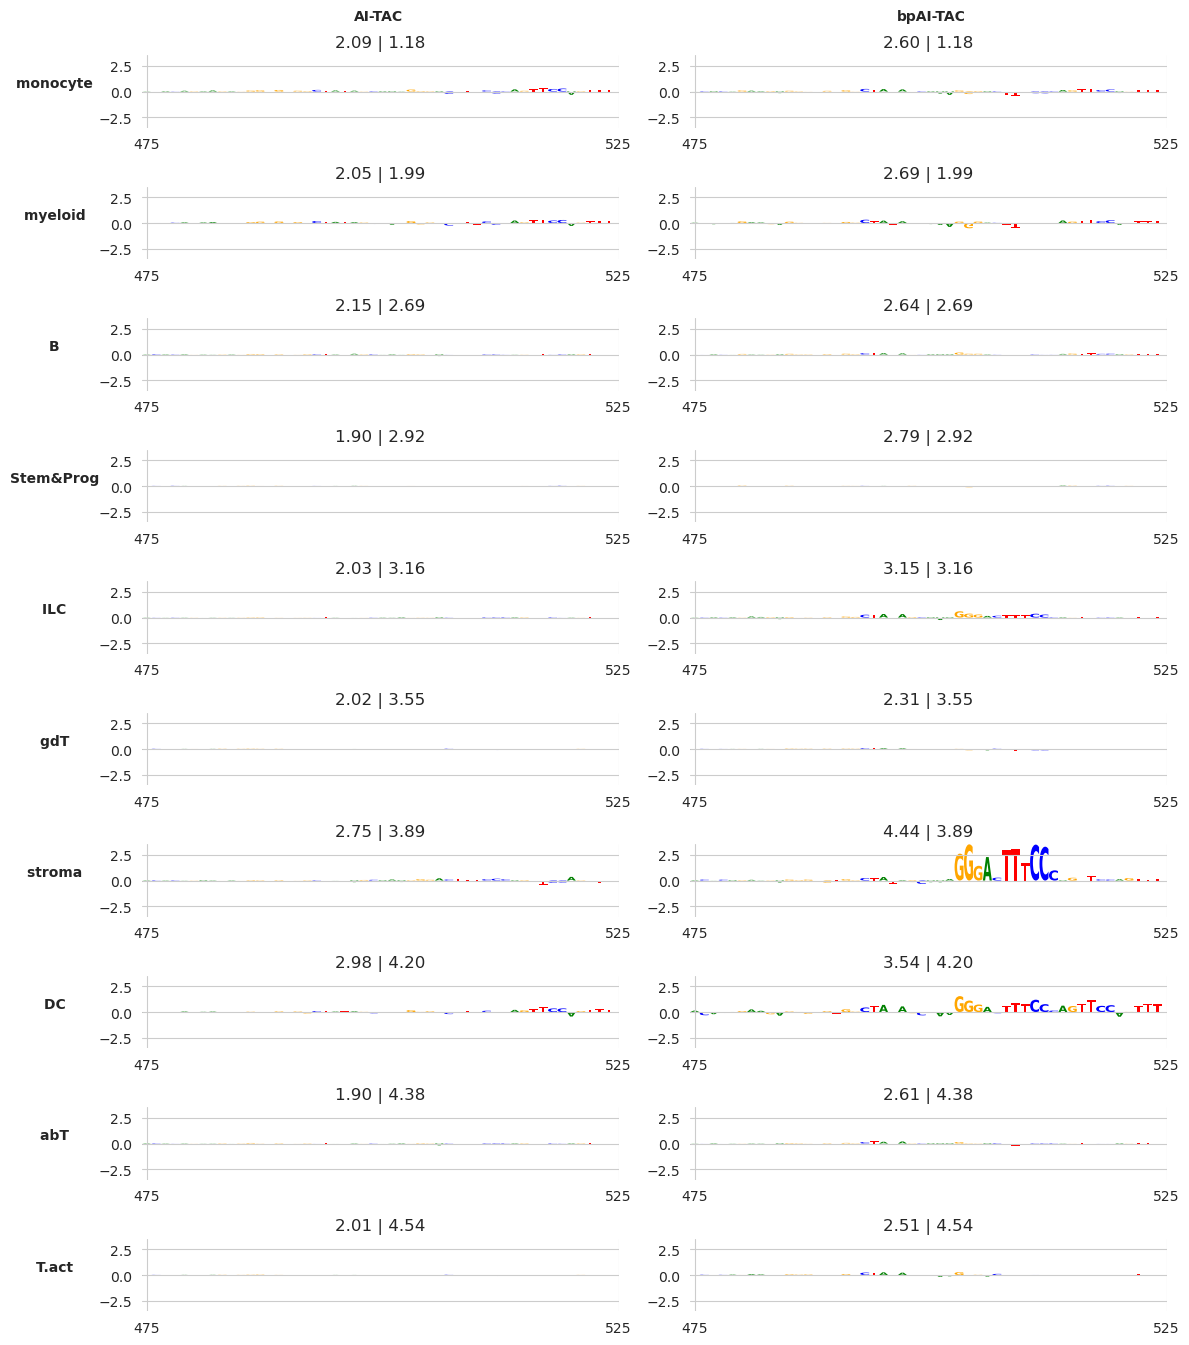

In [ ]:
# doing an REL motif with all the celltypes S5a

# specific_region_name = 'ImmGenATAC1219.peak_76113' # a region that shows REL
peak_num = 76113
# peak_num = 186667 # region that shows PTF1A 186667
specific_region_name = f'ImmGenATAC1219.peak_{peak_num}'
specific_region_idx = (np.where(saved_attributions['region_names'] == specific_region_name)[0])

print(attr_lineage_name)
# Note: these were calculated and saved in the image already. Here I have copied them over from the imate
test_set_idx = selected_idx[specific_region_idx]
print('test set peak name', peak_names[test_set_idx]) # IT's a MATCH!
region_obs_counts = load_observed(info_path, 'test', 'total_counts')[test_set_idx][0]
# peak_75132_region_obs_label

# Short version for main figure
peak_76113region_obs_label_short = ['', '','','','', '(low)', '(low)','','(medium)','(high)']
peak_76113_selected_lineages_short = ['ILC', 'DC', 'stroma']
plot_aitac_and_bpAITAC_logos_from_specific_celltypes(saved_attributions, lineage_model1, lineage_model2, peak_76113_selected_lineages_short, attr_lineage_name, specific_region_idx,
                                                    region_observed_label=peak_76113region_obs_label_short, outpath=f'final_figs/3b_peak_{peak_num}.png',
                                                    figsize=(7,3.5), show_logo_title_words=True)

# SUPPLEMENTARY FIGURE VERSION WITH COMPLETE CELLS
peak_76113_selected_lineages = 'all' # ['Stem&Prog', 'ILC', 'T.act', 'abT', 'gdT', 'B', 'monocyte', 'myeloid', 'DC', 'stroma']

region_obs_label = ["" for i in range(10)] # obs_total_counts[test_set_idx][0]I can't do this because it's not lineage based

plot_aitac_and_bpAITAC_logos_from_specific_celltypes(saved_attributions, lineage_model1, lineage_model2, peak_76113_selected_lineages, attr_lineage_name, specific_region_idx,
                                                    region_observed_label=region_obs_label, outpath=f'final_figs/S5a_peak_{peak_num}.png',
                                                    figsize=(12,14), 
                                                    tracks=lineage_cell_indices, cell_observed_counts=region_obs_counts, subplot_label='pred_and_obs',
                                                    show_logo_title_words=False)



In [ ]:
region_obs_counts

array([1.60222225e+01, 1.08888893e+01, 6.17777777e+00, 7.42222214e+00,
       1.70444450e+01, 1.59777775e+01, 3.08444443e+01, 3.05777779e+01,
       6.15999985e+01, 2.88888884e+00, 9.24444485e+00, 9.57777786e+00,
       2.91111112e+00, 1.23333330e+01, 7.51111126e+00, 6.17777777e+00,
       9.06666660e+00, 2.16444435e+01, 3.32000008e+01, 1.96444435e+01,
       2.50955551e+02, 2.05266663e+02, 1.45333338e+01, 9.28888893e+00,
       1.88888884e+00, 1.38888893e+01, 1.24222221e+01, 1.18000002e+01,
       3.40000000e+01, 4.36888885e+01, 6.49777756e+01, 5.80000019e+00,
       1.50222225e+01, 3.12222214e+01, 6.93333340e+00, 1.44666662e+01,
       7.22222233e+00, 1.06888885e+01, 1.47555552e+01, 3.11111122e-01,
       1.60666676e+01, 0.00000000e+00, 8.88888896e-01, 1.76444435e+01,
       1.41111107e+01, 1.11111112e-01, 6.40000010e+00, 8.31111145e+00,
       1.21333332e+01, 1.93333328e+00, 2.37777786e+01, 1.85555553e+01,
       1.68444443e+01, 8.19777756e+01, 1.09733330e+02, 2.95200012e+02,
      

#### Supplmentary figure 9: attribution of zero bias and bias model

In [ ]:
def plot_two_models_logos_from_specific_celltypes(region_onehot, model1_attribution, model2_attribution, lineage_model1, lineage_model2, selected_lineages, 
                                                  lineage_names_list, specific_region_idx, region_observed_label, outpath, model1_label, model2_label, figsize=(12,5), tracks=None, cell_observed_counts=None):
    """
    region_observed_label should be a list with labels such as '' and '(medium)' and '(high)' and '(low)' or just the observed total counts
    """
    if tracks: # tracks is lineage cell indices 
        tc_lineage = np.zeros(len(tracks))
        for i, track_group in enumerate(tracks):
            tc_lineage[i] = np.mean(cell_observed_counts[track_group])
        tc = tc_lineage
        print('tc lineage', tc.shape, tc)
    
    # make selected lineages be the lineages ordered by the number of tc
    tc_ordered_args = np.argsort(tc_lineage)
    if selected_lineages == 'all':
        selected_lineages = lineage_names_list[tc_ordered_args]

    cell_idx_list = [i for lineage in selected_lineages for i in np.where(lineage_names_list == lineage)[0]]
    print('cell_idx_list', cell_idx_list)


    _, l1_tc_pred = get_pred(lineage_model1, region_onehot[0].astype(np.float32), region_bias=np.zeros((1, 998)))
    _, l2_tc_pred = get_pred(lineage_model2, region_onehot[0].astype(np.float32), region_bias=np.zeros((1, 998)))

    print('l1_tc_pred', l1_tc_pred.shape)
    onehot_multiplier = np.repeat(region_onehot, len(lineage_names), axis=0) # to multiply by X_attr_all to get single existing base pair at a given region


    region_l0_attr = np.squeeze(model1_attribution) * onehot_multiplier
    region_lp5_attr = np.squeeze(model2_attribution) * onehot_multiplier
    print('region_l0_attr',region_l0_attr.shape)
    print('region_lp5_attr',region_lp5_attr.shape)
    region_compare_two_model_logos_across_celltypes(model0_X_attr=region_l0_attr,
                                                    modelP_X_attr=region_lp5_attr,
                                                    model0_pred_tc=l1_tc_pred, modelP_pred_tc=l2_tc_pred,
                                                    region_obs_total_counts=region_observed_label,
                                                    cell_idx=cell_idx_list,
                                                    cell_names=lineage_names_list,
                                                    region_name='',
                                                    outpath=outpath, model0_name=model1_label, modelP_name=model2_label,
                                                    figsize=figsize,
                                                    x_threshold_percent=0.4,
                                                    )

In [ ]:
path_zero_bias_model = '/homes/gws/nchand/MostafaviLab/results/BPcm_bias0/BP127_L-1_5/complete/12-26-2024.18.38/best_model'
model_zero_bias = load_model(path_zero_bias_model, model_structure=get_model_structure('BPcm_bias0', 300, n_celltypes), n_filters=300, verbose=True)

lineage_model_zero_bias = AverageWrapper(model_zero_bias, lineage_cell_indices)
wrapped_model_zero_bias = AttributionModelWrapper(lineage_model_zero_bias)
lineage_model_bpAITAC_250 = lineage_model2

peak_num = 195921
specific_region_name = f'ImmGenATAC1219.peak_{peak_num}' # a region that shows two potential motifs learned
specific_region_idx = (np.where(saved_attributions['region_names'] == specific_region_name)[0])


# get attributions for the zero bias model
region_onehot = saved_attributions['onehot_seq'][specific_region_idx]
print(region_onehot.shape)
# region_onehot_expanded = np.expand_dims(region_onehot, axis=0)

test_set_idx = selected_idx[specific_region_idx]
print('test set peak name', peak_names[test_set_idx]) # IT's a MATCH!
region_obs_counts = load_observed(info_path, 'test', 'total_counts')[test_set_idx][0]

model_bz_X_attr_all = attributions(wrapped_model_zero_bias, region_onehot, cell_idx=range(len(lineage_names)), attribution_type='deep_lift_shap', hypothetical=True) 

print('model_bz_X_attr_all', model_bz_X_attr_all.shape)


region_obs_label = ["" for i in range(10)] # obs_total_counts[test_set_idx][0]I can't do this because it's not lineage based

selected_lineages = 'all' # ['Stem&Prog', 'ILC', 'T.act', 'abT', 'gdT', 'B', 'monocyte', 'myeloid', 'DC', 'stroma']
lineage_names_list=lineage_names




199
39
7
DEVICE is cuda:2
998 300 90
MODEL STRUCTURE BPcm_bias0(
  (body): Body(
    (net): Sequential(
      (0): Conv1d(4, 300, kernel_size=(25,), stride=(1,), padding=same)
      (1): DialatedConvs(
        (net): Sequential(
          (0): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (1): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (2): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilat

/homes/gws/nchand/MostafaviLab/bpAITAC/load_model.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


(1, 4, 998)
test set peak name ['ImmGenATAC1219.peak_188319']
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/test.total_counts.dat
model_bz_X_attr_all (10, 4, 998)


tc lineage (10,) [ 19.42222214  16.85965157  23.5851841   10.87407398  11.27619076
  10.63111115  89.10303497  11.25555611 104.08443451  13.6799984 ]
cell_idx_list [5, 3, 7, 4, 9, 1, 0, 2, 6, 8]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
l1_tc_pred (10,)
region_l0_attr (10, 4, 998)
region_lp5_attr (10, 4, 998)
v lim -5.389864444732666 5.389864444732666
THRESHOLD IS 2.1559457778930664
[491]
THRESHOLD IS 2.1559457778930664
[490 491 493 494]
x lim (475, 525)
celltype: ILC
cell_tc 
celltype: T.act
cell_tc 
celltype: monocyte
cell_tc 
celltype: gdT
cell_tc 
celltype: stroma
cell_tc 
celltype: B
cell_tc 
celltype: Stem&Prog
cell_tc 
celltype: abT
cell_tc 
celltype: myeloid
cell_tc 
celltype: DC
cell_tc 


<Figure size 640x480 with 0 Axes>

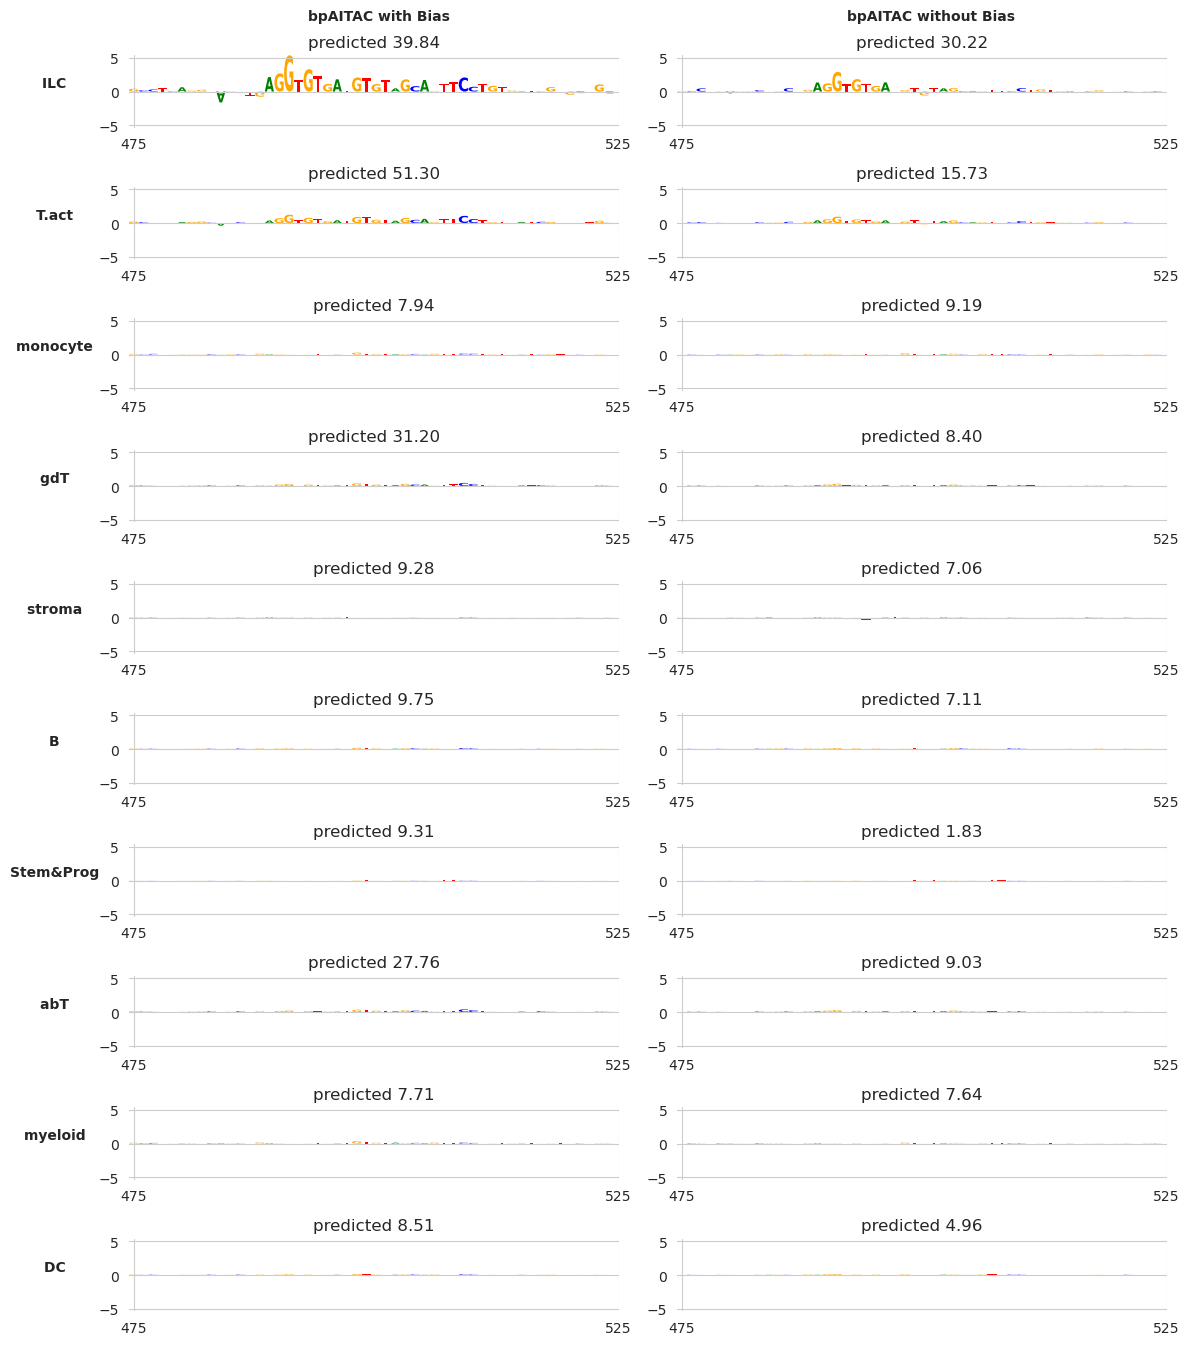

In [ ]:

plot_two_models_logos_from_specific_celltypes(region_onehot, model1_attribution=saved_attributions['L0p5_attributions'][specific_region_idx],
                                              model2_attribution=model_bz_X_attr_all,
                                              lineage_model1=lineage_model_bpAITAC_250, lineage_model2=lineage_model_zero_bias,
                                              selected_lineages=peak_76113_selected_lineages,
                                              lineage_names_list=attr_lineage_name,
                                              specific_region_idx=specific_region_idx,
                                              region_observed_label=region_obs_label,
                                              outpath=f'final_figs/S9_attributions_bias_zero_peak_{peak_num}.png',
                                              model1_label='bpAITAC with Bias',
                                              model2_label='bpAITAC without Bias',
                                              figsize=(12,14),
                                              tracks=lineage_cell_indices,
                                              cell_observed_counts=region_obs_counts)

In [ ]:
specific_region_name = 'ImmGenATAC1219.peak_75132' # a region that shows two potential motifs learned
specific_region_idx = (np.where(saved_attributions['region_names'] == specific_region_name)[0])


# get attributions for the zero bias model
region_onehot = saved_attributions['onehot_seq'][specific_region_idx]
print(region_onehot.shape)
model_bz_X_attr_all_75132 = attributions(wrapped_model_zero_bias, region_onehot, cell_idx=range(len(lineage_names)), attribution_type='deep_lift_shap', hypothetical=True) 
print('model_bz_X_attr_all', model_bz_X_attr_all.shape)
region_obs_label = ["" for i in range(10)] # obs_total_counts[test_set_idx][0]I can't do this because it's not lineage based

peak_75132_selected_lineages = ['Stem&Prog', 'ILC', 'myeloid', 'stroma', 'monocyte','T.act','gdT','DC','abT','B']

(1, 4, 998)


KeyboardInterrupt: 

In [ ]:
model_bz_X_attr_all_75132.shape

(10, 4, 998)

In [ ]:
start_idx=375
end_idx=625
plot_two_models_logos_from_specific_celltypes(region_onehot, model1_attribution=saved_attributions['L0p5_attributions'][specific_region_idx],
                                              model2_attribution=model_bz_X_attr_all_75132,
                                              lineage_model1=lineage_model_bpAITAC_250, lineage_model2=lineage_model_zero_bias,
                                              selected_lineages=peak_75132_selected_lineages,
                                              lineage_names_list=attr_lineage_name,
                                              specific_region_idx=specific_region_idx,
                                              region_observed_label=region_obs_label,
                                              outpath='final_figs/S9_attributions_bias_zero_peak_75132.png',
                                              model1_label='bpAITAC with Bias',
                                              model2_label='bpAITAC without Bias',
                                              figsize=(12,14),
                                              )
assert False

NameError: name 'plot_two_models_logos_from_specific_celltypes' is not defined

## Get the profiles when bias is set to 0 of the L=0.5 model 

In [ ]:

selected_idx = regions_meet_all_criteria_v3(info_path, eval_set, model1_corr, model2_corr)

print(path_model2) # double check it's the expected model 
model = lineage_model2
n_cells = len(lineage_names)


onehot_encoding = load_observed(info_file=info_path, dataset_type=eval_set, data_name= 'onehot')

pred_profile = np.zeros((len(selected_idx), n_cells, 998))
region_names = []

for index, region_idx in enumerate(selected_idx):
    region_name = peak_names[region_idx]
    region_names.append(region_name)
    # find the one hot encoding of this region
    region_onehot = np.array(onehot_encoding[region_idx]) # convert from memmap -> numpy array
    region_onehot = region_onehot.transpose(1, 0)
    zero_bias = np.zeros((1, 998))
    region_pred_profile, region_pred_total_counts = get_pred(model, region_onehot, zero_bias)
    pred_profile[index] = region_pred_profile

print(pred_profile)


17062 regions meet criteria of good prediction for model2
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_bias_BP106_L0_1_corrected_normalized_11.7.24/memmap/test.total_counts.dat
shape max tc (32361,)
Mean coefficient of variation: 1.3709954
21957 regions meet criteria of coefficient of variation between celltypes
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_bias_BP106_L0_1_corrected_normalized_11.7.24/memmap/test.total_counts.dat
mean max tc 275.53253
15380 regions meet criterion of sufficient total counts more than 150
146 regions meet all 4 criteria
/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP126_L-1_5/complete/11-17-2024.11.51/best_model
file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_bias_BP106_L0_1_corrected_normalized_11.7.24/memmap/test.onehot.dat
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])


ValueError: could not broadcast input array from shape (10,250) into shape (10,998)

In [ ]:
outdir = '/data/nchand/analysis/BPcm/BP68_analysis/testing_lineage_v3'
filename = "BP68_L0.5_selected_region_profile_bias0_v3.npz"
np.savez(outdir+filename,
         profiles=pred_profile, region_names=region_names, lineage_names=lineage_names)

NameError: name 'pred_profile' is not defined

In [ ]:
f = np.load(outdir+filename)
p = f['profiles']


NameError: name 'outdir' is not defined

In [ ]:
def get_scalar_preds(model, n_examples, onehot_seq, bias):
    predicted_scalars = np.zeros((n_examples, len(lineage_names)))
    for i in range(n_examples):
        region_onehot = onehot_seq[i]
        region_bias = bias[i]
        pred_prof, pred_scalar = get_pred(model, region_onehot, region_bias)
        print(pred_prof),
        predicted_scalars[i] = pred_scalar
    return predicted_scalars

# Marginalization

In [ ]:
import numpy as np

In [ ]:
REL = "GGGAATTTCCC"
PTF1A = "TTCACACCTG"
MOTIF_53 = "GCAGCGGTATAGTACAGCCC"
PAX5 = "GGAGCACTGAAGCGTAGCCG"
SPI1 = "AAAAAGAGGAAGTG"
EOMES = "AAGGTGTGAAAA"
RUNX = "TCTGTGGTTT"
C_EBP = "CCAAT"
CTCF = "TGGCCACCAGGGGGCGCTA"

bases = ['A', 'C', 'G', 'T'] # from /data/nchand/mm10/mm10ImmGenATAC1219.peak_matched1000bp_onehot-ACGT_alignleft.npz


Get the predictions for the lambda=0.5 model 

In [ ]:
from tangermeme.utils import random_one_hot

import torch

from tangermeme.utils import one_hot_encode

motif = REL
motif_name = "REL"
n_sequences = 1000
model_profile_out_seq_len =  250 # or 998
seq_len = 998

X = random_one_hot((n_sequences, 4, seq_len)).type(torch.float32)  # Generate 100 random sequences to marginalize over

motif_onehot = one_hot_encode(motif).unsqueeze(0)
motifs = {"REL": motif_onehot}
print(type(motif_onehot))



<class 'torch.Tensor'>


In [ ]:
print(torch.__version__)

1.12.1


In [ ]:
from tangermeme.utils import random_one_hot
from tangermeme.marginalize import marginalize
from tangermeme.predict import predict
from AttributionModelProfileWrapper_Bias0 import AttributionModelProfileWrapper_Bias0
from tangermeme.ersatz import substitute


def get_marginalized(X, input_model, input_sequence):

    model= AttributionModelProfileWrapper_Bias0(input_model)
    
    print(X.shape)
    y_before, y_after = marginalize(model, X, input_sequence, device='cpu')
    print('y before and after shape', y_before.shape, y_after.shape)


    # get predictions from model with bias 
    return y_before, y_after

Trying out the new model- inserting for the old

In [ ]:
from load_model import load_model
from utils import get_least_utilized_gpu
from AttributionModelWrapper import AttributionModelWrapper
from modules import AverageWrapper
from region_identification_utils import get_lineage_cells



n_celltypes = 90
path_model1='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP129_L0_0/complete/12-15-2024.18.19/best_model'
path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP126_L-1_5/complete/11-17-2024.11.51/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP126_L-1_9/complete/12-29-2024.17.35/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP129_L-1_5/complete/11-19-2024.11.52/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP128_L-1_5/complete/11-17-2024.11.52/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP129_L-1_5/complete/11-19-2024.11.41/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP132_L-1_5/complete/12-23-2024.11.20/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP133_L-1_5/complete/12-26-2024.13.12/best_model'
# path_model2='/homes/gws/nchand/MostafaviLab/results/BPcm_bias0/BP127_L-1_5/complete/12-26-2024.18.38/best_model'
# sample_model='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP126_L-1_5/sample/11-17-2024.11.37/best_model'
# path_model2=sample_model
start_idx=0 
end_idx=250

# load the model
model1 = load_model(path_model1, model_structure=get_model_structure('BPcm_250', 300, n_celltypes), n_filters=300, verbose=True)
wrapped_model1 = AttributionModelWrapper(model1)
model2 = load_model(path_model2, model_structure=get_model_structure('BPcm_250', 300, n_celltypes, seq_len=seq_len), n_filters=300, verbose=False)
wrapped_model2 = AttributionModelWrapper(model2)
# model3 = load_model(path_model3, model_structure=get_model_structure('BPcm_250', 300, 90), n_filters=300, verbose=False)
# wrapped_model3 = AttributionModelWrapper(model3)

lineage_names, lineage_cell_indices = get_lineage_cells(lineage_filepath, cell_names=cell_names)

lineage_model1 = AverageWrapper(model1, lineage_cell_indices)
lineage_model2 = AverageWrapper(model2, lineage_cell_indices)
# lineage_model3 = AverageWrapper(model3, lineage_cell_indices)

199
39
7
DEVICE is cuda:3
998 300 90
MODEL STRUCTURE BPcm_250(
  (body): Body(
    (net): Sequential(
      (0): Conv1d(4, 300, kernel_size=(25,), stride=(1,), padding=same)
      (1): DialatedConvs(
        (net): Sequential(
          (0): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (1): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilation=(4,))
              (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
            )
          )
          (2): ResBlock(
            (conv_block): Sequential(
              (0): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same, dilatio

/homes/gws/nchand/MostafaviLab/bpAITAC/load_model.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


199
39
7
DEVICE is cuda:3
998 300 90


In [ ]:
y_before_p5, y_after_p5 = get_marginalized(X, lineage_model2, motif)

torch.Size([1000, 4, 998])
y before and after shape torch.Size([1000, 10, 250]) torch.Size([1000, 10, 250])


Get an example prediction from model2

In [ ]:
X_cpu = X.cpu()
substitute_x = substitute(X, motif).cpu()

model2_cpu = model2.cpu()
bias = torch.zeros((X.shape[0], X.shape[2]))
bias = bias.cpu()
profile, scalar = model2(substitute_x, bias)

In [ ]:
substitute_x = substitute(X, motif)
model= AttributionModelProfileWrapper_Bias0(lineage_model2)
pred = predict(model, substitute_x, device='cpu')

KeyboardInterrupt: 

In [ ]:
print(y_before_p5.shape)
print(y_before_p5[0, 0, 245:255])

torch.Size([1000, 10, 250])
tensor([0.0040, 0.0027, 0.0028, 0.0090, 0.0018])


In [ ]:
model_num = 'BP126'
save_dir_name = f'{model_num}_analysis'
version_num = '3'

In [ ]:
# from tangermeme.utils import characters
# save_dir_name = 'BP68_analysis'

save_dir = f'/data/nchand/analysis/BPcm/{save_dir_name}/testing_lineage_v{version_num}'
save_file_p5 = os.path.join(save_dir, f'{model_num}_{motif_name}_p5.npz')
save_file_p0 = os.path.join(save_dir, f'{model_num}_{motif_name}_p0.npz')
save_file_p1 = os.path.join(save_dir, f'{model_num}_{motif_name}_p1.npz')
os.makedirs(save_dir, exist_ok=True)

# save_file = f'/data/nchand/analysis/BPcm/{save_dir_name}/testing_lineage_v{version_num}/lp5_{n_sequences}_marginalization_{motif_name}.npz'

In [ ]:
np.savez(save_file_p5, y_before=y_before_p5, y_after=y_after_p5, before_insertion_seq=X, after_insertion_seq=X_after_insertion, lineage_names=lineage_names, bases=bases)

marg_p5 = np.load(save_file_p5)
y_before_p5, y_after_p5 = marg_p5['y_before'], marg_p5['y_after'] 


In [ ]:
marg_p5 = np.load(save_file_p5)
y_before_p5, y_after_p5 = marg_p5['y_before'], marg_p5['y_after'] 

Get the predictions for the lambda=0 model

In [ ]:
y_before_0, y_after_0 = get_marginalized(X, lineage_model1, motif)
np.savez(save_file_p0, y_before=y_before_0, y_after=y_after_0, before_insertion_seq=X, after_insertion_seq=X_after_insertion, lineage_names=lineage_names, bases=bases)

torch.Size([1000, 4, 998])
y before and after shape torch.Size([1000, 10, 250]) torch.Size([1000, 10, 250])


In [ ]:
marg_0 = np.load(save_file_p0)
y_before_0, y_after_0 = marg_0['y_before'], marg_0['y_after']
# marg_p5 = np.load(save_file_p5)
# y_before_p5, y_after_p5 = marg_p5['y_before'], marg_p5['y_after'] 

before_insertion_seq, after_insertion_seq = marg_0['before_insertion_seq'], marg_0['after_insertion_seq']

In [ ]:
# y_before_1, y_after_1 = get_marginalized(X, lineage_model3, motif)
# np.savez(save_file_p1, y_before=y_before_1, y_after=y_after_1, before_insertion_seq=X, after_insertion_seq=X_after_insertion, lineage_names=lineage_names, bases=bases)
# marg_1 = np.load(save_file_p1)
# y_before_1, y_after_1 = marg_1['y_before'], marg_1['y_after']

torch.Size([1000, 4, 998])
y before and after shape torch.Size([1000, 10, 250]) torch.Size([1000, 10, 250])


In [ ]:
# yb = torch.nn.functional.softmax(y_before_p5.mean(axis=0), dim=-1) 
# ya = torch.nn.functional.softmax(y_after_p5.mean(axis=0), dim=-1)
# print('yb shape', yb.size())

# plt.figure(figsize=(6, 4))
# plt.plot(yb[4, 475:525], color='b', linewidth=1, label=" strand before")
# # plt.plot(yb[1], color='0.3', linewidth=1, label="- strand before")

# plt.plot(ya[4, 475:525], color='r', linewidth=1, label="strand after")
# # plt.plot(ya[1], color='b', linewidth=1, label="- strand after")
# plt.xlabel("Genomic Position")
# plt.ylabel("Predicted Probability")
# plt.legend(fontsize=8)
# plt.show()

In [ ]:
def moving_average(data, window_size):
    """
    Calculate moving average over the genomic positions.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data array
    window_size : int
        Size of the averaging window (number of base pairs)
        
    Returns:
    --------
    numpy.ndarray
        Smoothed data array
    """
    if window_size <= 1:
        return data
        
    kernel = np.ones(window_size) / window_size
    if len(data.shape) == 3:  # (n_samples, n_lineages, sequence_length)
        smoothed = np.zeros_like(data)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                smoothed[i, j] = np.convolve(data[i, j], kernel, mode='same')
    else:  # (n_lineages, sequence_length)
        smoothed = np.zeros_like(data)
        for i in range(data.shape[0]):
            smoothed[i] = np.convolve(data[i], kernel, mode='same')
    return smoothed


In [ ]:
def plot_genomic_predictions_std(y_before, y_after, lineage_names, motif_name, start_idx=375, end_idx=625, figsize=(8, 20)):
    """
    Create subplots comparing before and after genomic predictions for multiple lineages,
    including standard deviation visualization for the 'after' predictions.
    
    Parameters:
    -----------
    y_before : torch.Tensor or numpy.ndarray
        Predictions before, shape should be (n_samples, n_lineages, sequence_length)
    y_after : torch.Tensor or numpy.ndarray
        Predictions after, shape should be (n_samples, n_lineages, sequence_length)
    lineage_names : list of str
        Names of lineages to use as subplot titles
    motif_name : str
        Name of the motif being analyzed
    start_idx : int, optional
        Starting index for the sequence window (default: 375)
    end_idx : int, optional
        Ending index for the sequence window (default: 625)
    figsize : tuple of int, optional
        Figure size in inches (width, height) (default: (8, 20))
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : numpy.ndarray
        Array of subplot axes objects
    """
    # Calculate mean and standard deviation
    yb = y_before.mean(axis=0)
    ya = y_after.mean(axis=0)
    print('yb shape', yb.shape)
    ya_std = y_after.std(axis=0)
    
    print('yb shape', yb.shape)
    # Convert to numpy if tensors
    if hasattr(yb, 'numpy'):
        yb = yb.numpy()
    if hasattr(ya, 'numpy'):
        ya = ya.numpy()
    if hasattr(ya_std, 'numpy'):
        ya_std = ya_std.numpy()
    
    # Find global min and max values across all data, including std deviation ranges
    all_data = np.concatenate([
        yb[:, start_idx:end_idx].flatten(),
        (ya[:, start_idx:end_idx] + ya_std[:, start_idx:end_idx]).flatten(),
        (ya[:, start_idx:end_idx] - ya_std[:, start_idx:end_idx]).flatten()
    ])
    global_min = np.min(all_data)
    global_max = np.max(all_data)
    
    # Add small padding to min/max for better visualization
    padding = (global_max - global_min) * 0.05
    y_min = global_min - padding
    y_max = global_max + padding
    
    # Create figure and subplots
    fig, axes = plt.subplots(len(lineage_names), 1, figsize=figsize)
    if len(lineage_names) == 1:
        axes = [axes]  # Make axes iterable when there's only one subplot
    fig.tight_layout(pad=3.0)
    
    # Create x-axis values for plotting
    x = np.arange(start_idx, end_idx)
    
    # Plot each index
    for i, lineage in enumerate(lineage_names):
        ax = axes[i]
        
        # Plot the before line (blue)
        ax.plot(x, yb[i, start_idx:end_idx], color='b', linewidth=1, label=f"{motif_name}")
        
        # Plot the after line (red) with standard deviation
        ax.plot(x, ya[i, start_idx:end_idx], color='r', linewidth=1, label=f"no {motif_name}")
        ax.fill_between(x, 
                       ya[i, start_idx:end_idx] - ya_std[i, start_idx:end_idx],
                       ya[i, start_idx:end_idx] + ya_std[i, start_idx:end_idx],
                       color='r', alpha=0.2, label='Standard Deviation')
        
        # Set consistent y-axis limits
        ax.set_ylim(y_min, y_max)
        
        # Add labels and title for each subplot
        ax.set_ylabel("Predicted Probability")
        ax.set_title(f"{lineage}")
        ax.legend(fontsize=8)
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add x-label only to bottom subplot
    axes[-1].set_xlabel("Genomic Position")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Print the range for reference
    print(f"Y-axis range: [{y_min:.3f}, {y_max:.3f}]")
    
    return fig, axes

# Example usage:
# fig, axes = plot_genomic_predictions(y_before, y_after, lineage_names, motif_name)
# plt.show()

In [ ]:
def plot_genomic_predictions(y_before, y_after, lineage_names, motif_name, 
                             title="Genomic Predictions", start_idx=375, end_idx=625, 
                             figsize=(10, 20), band_type="std"):
    """
    Create genomic prediction plots with proper scaling.
    Includes standard deviation or quartile bands around the mean lines.
    
    Parameters:
    -----------
    y_before, y_after : Prediction arrays
    lineage_names : list of str
        Names of lineages to use as subplot titles
    motif_name : str
        Name of the motif for legend
    title : str
        Title of the plot
    start_idx, end_idx : int
        Start and end indices for the genomic window
    figsize : tuple
        Figure size (width, height)
    band_type : str
        Type of band to plot ('std' or 'quartile')
    """
    def process_input(x, band_type="std"):
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
            
        if not isinstance(x, np.ndarray):
            raise TypeError("Input must be either a PyTorch tensor or NumPy array")
            
        x_mean = x.mean(axis=0)
        
        if band_type == "std":
            x_std = x.std(axis=0)
            x_upper = x_mean + x_std
            x_lower = x_mean - x_std
            return x_mean, x_upper, x_lower
        elif band_type == "quartile":
            x_lower = np.percentile(x, 25, axis=0)
            x_upper = np.percentile(x, 75, axis=0)
            x_median = np.median(x, axis=0)
            print('median shape', x_median.shape)
            return x_median, x_upper, x_lower
        else:
            raise ValueError("band_type must be either 'std' or 'quartile'")
        
    # Process inputs
    yb_mean, yb_upper, yb_lower = process_input(y_before, band_type)
    ya_mean, ya_upper, ya_lower = process_input(y_after, band_type)
    
    # Create figure and grid
    fig, axes = plt.subplots(len(lineage_names), 1, figsize=figsize)
    if len(lineage_names) == 1:
        axes = [axes]
    
    # Find global min/max for consistent scaling
    all_data = np.concatenate([
        yb_mean[:, start_idx:end_idx].flatten(),
        ya_mean[:, start_idx:end_idx].flatten(),
        yb_upper[:, start_idx:end_idx].flatten(),
        yb_lower[:, start_idx:end_idx].flatten(),
        ya_upper[:, start_idx:end_idx].flatten(),
        ya_lower[:, start_idx:end_idx].flatten()
    ])
    
    print(yb_mean.shape)
    print(yb_mean[:, start_idx:end_idx])
    global_min = np.min(all_data)
    global_max = np.max(all_data)
    padding = (global_max - global_min) * 0.05
    y_min = global_min - padding
    y_max = global_max + padding
    
    x_values = np.arange(start_idx, end_idx)
    band_label = "±1 std dev" if band_type == "std" else "quartile band"

    # Plot each lineage
    for i, lineage in enumerate(lineage_names):
        # Plot bands
        axes[i].fill_between(x_values, 
                           yb_lower[i, start_idx:end_idx],
                           yb_upper[i, start_idx:end_idx],
                           color='b', alpha=0.2)
        axes[i].fill_between(x_values,
                           ya_lower[i, start_idx:end_idx],
                           ya_upper[i, start_idx:end_idx],
                           color='r', alpha=0.2)
        
        # Plot mean lines
        axes[i].plot(x_values, yb_mean[i, start_idx:end_idx], color='b', 
                    linewidth=1, label=f"no {motif_name}")
        axes[i].plot(x_values, ya_mean[i, start_idx:end_idx], color='r',
                    linewidth=1, label=f"{motif_name}")
        
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_ylabel(f"{lineage}\n")
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        if i == 0:
            axes[i].set_title(title)
            axes[i].legend(fontsize=8)
    
    # Add x-label to bottom plot
    axes[-1].set_xlabel("Genomic Position")
    
    plt.subplots_adjust(hspace=0.3)
    
    return fig, axes

250

median shape (10, 250)
median shape (10, 250)
(10, 250)
[[0.00209757 0.00216351 0.00207769 ... 0.0019184  0.00194142 0.00201041]
 [0.00200881 0.00210438 0.00193954 ... 0.00190926 0.00190379 0.00195344]
 [0.00177083 0.00177592 0.00169722 ... 0.00173831 0.00173602 0.00176135]
 ...
 [0.00197826 0.00206092 0.00198993 ... 0.00190768 0.00190302 0.00198485]
 [0.00187988 0.00189617 0.00180177 ... 0.00178177 0.00176987 0.00185712]
 [0.00182546 0.00189806 0.00185169 ... 0.00173872 0.00169597 0.00173906]]


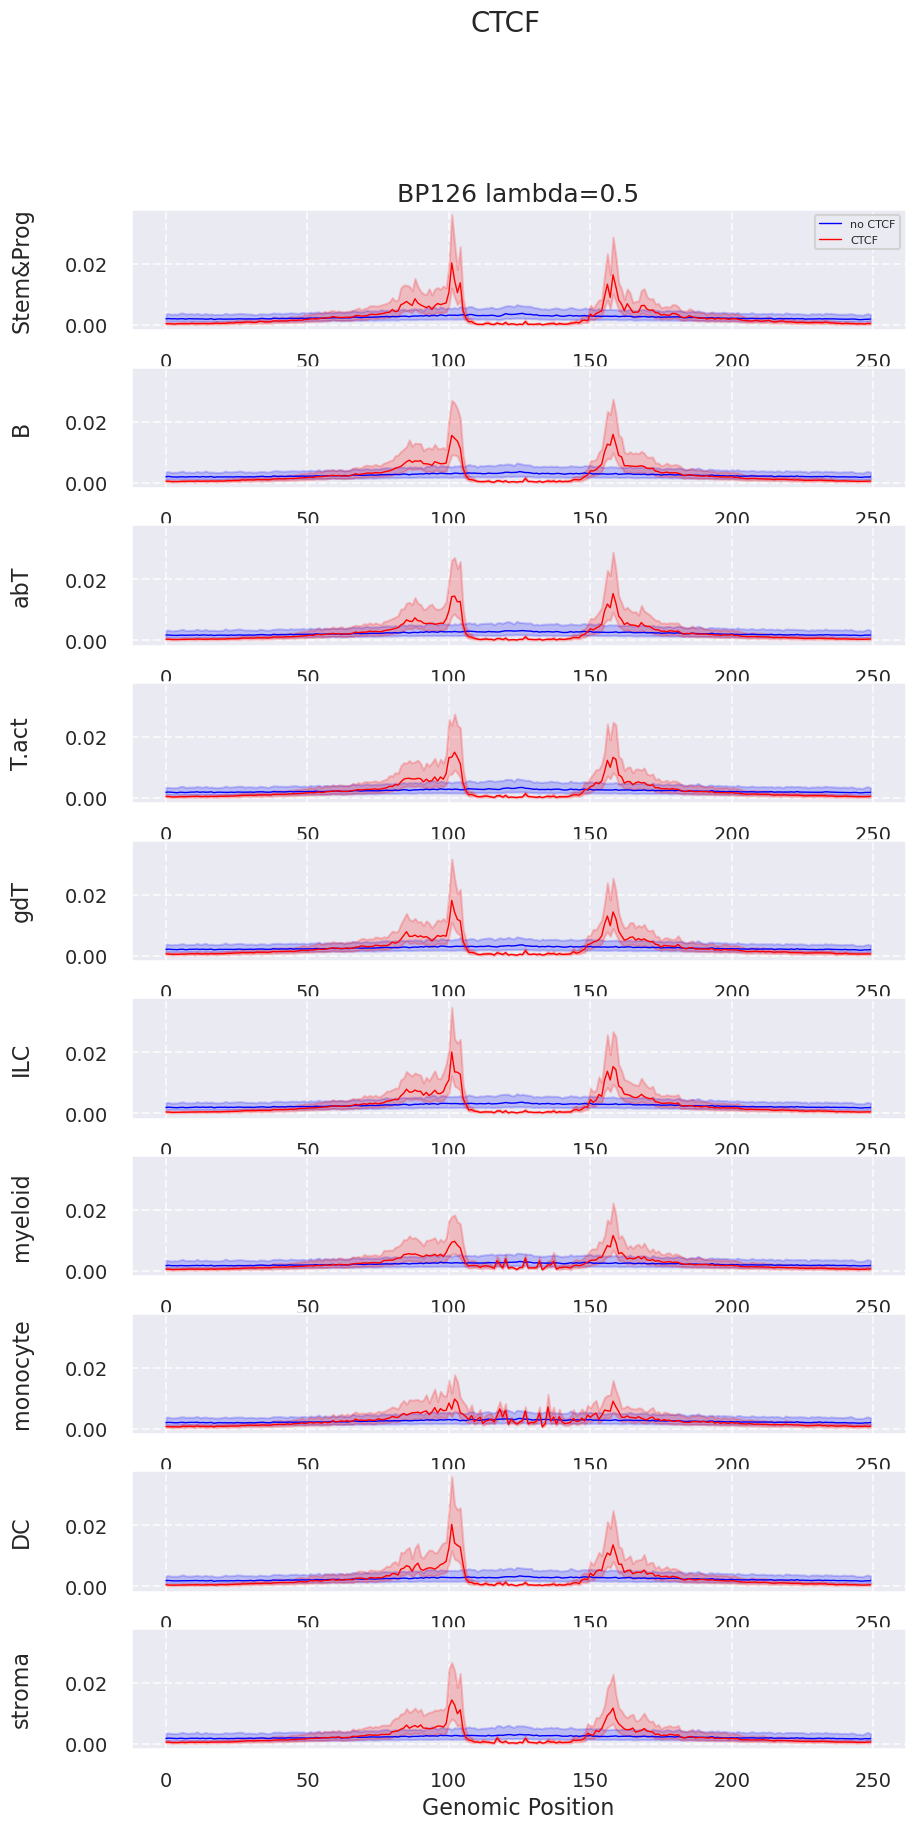

In [ ]:
window_size = 1
specific_idx = 10
start_idx = 200
end_idx = 800

# y_before_p5_plot = y_before_p5[specific_idx:specific_idx+1] 
# y_after_p5_plot = y_after_p5[specific_idx:specific_idx+1]
# y_before_p5_plot = y_before_p5
# y_after_p5_plot = y_after_p5
# print('ybp size', y_before_p5.shape)
# fig, axes = plot_genomic_predictions(torch.tensor(y_before_p5_plot), torch.tensor(y_after_p5_plot), lineage_names, motif_name, start_idx=start_idx, end_idx=end_idx, band='quartile')
# save_name  = f'{model_num}_1seq_{window_size}_idx{specific_idx}.png'
# fig.savefig(save_name)
# print(f'saved fig at: {save_name}')
# fig.show()


fig, axes = plot_genomic_predictions(y_before_p5, y_after_p5, 
                                      lineage_names, motif_name, title=f'{model_num} lambda=0.5', start_idx=375, end_idx=625, 
                                      figsize=(10, 20),
                                      band_type='quartile')
fig.suptitle(f'{motif_name}')  
fig.savefig(f'test_{model_num}_l5_{motif_name}_quartile.png')
fig.savefig(f'{save_dir}/L5_{motif_name}_quartile.png')
# plot_genomic_predictions_std(torch.tensor(y_before_p5), torch.tensor(y_after_p5), lineage_names, motif_name, start_idx=start_idx, end_idx=end_idx)

In [ ]:
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt

def plot_genomic_predictions_comparison(y_before1, y_after1, y_before2, y_after2, 
                                      lineage_names, motif_name, titles=("Plot 1", "Plot 2"), start_idx=375, end_idx=625, 
                                      figsize=(20, 20),
                                      band_type="std",
                                      relative_position_labels=False
                                      ):
    """
    Create two sets of genomic prediction plots side by side with proper scaling.
    Includes standard deviation bands around the mean lines.
    
    Parameters:
    -----------
    y_before1, y_after1 : First set of predictions
    y_before2, y_after2 : Second set of predictions
    lineage_names : list of str
        Names of lineages to use as subplot titles
    start_idx, end_idx : int
        Start and end indices for the genomic window
    figsize : tuple
        Figure size (width, height)
    """
    

    def process_input(x, band_type="std"):  # Added band_type parameter
        """Helper function to process input arrays and calculate bounds"""
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
            
        if not isinstance(x, np.ndarray):
            raise TypeError("Input must be either a PyTorch tensor or NumPy array")
            
        # Calculate mean
        x_mean = x.mean(axis=0)
        
        # Calculate bounds based on band_type
        if band_type == "std":
            x_std = x.std(axis=0)
            x_upper = x_mean + x_std
            x_lower = x_mean - x_std
            return x_mean, x_upper, x_lower
        elif band_type == "quartile":
            x_lower = np.percentile(x, 25, axis=0)
            x_upper = np.percentile(x, 75, axis=0)
            x_median = np.median(x, axis=0)
            return x_median, x_upper, x_lower
        else:
            raise ValueError("band_type must be either 'std' or 'quartile'")
            

    # Process all inputs
    yb1_mean, yb1_upper, yb1_lower = process_input(y_before1, band_type)
    ya1_mean, ya1_upper, ya1_lower = process_input(y_after1, band_type)
    yb2_mean, yb2_upper, yb2_lower = process_input(y_before2, band_type)
    ya2_mean, ya2_upper, ya2_lower = process_input(y_after2, band_type)
    
    print('yb mean, and yb upper', yb1_mean.shape, yb1_upper.shape)
    
    # Create figure and grid
    fig, axes = plt.subplots(len(lineage_names), 2, figsize=figsize)
        
    # Find global min/max for consistent scaling
    all_data = np.concatenate([
        yb1_mean[:, start_idx:end_idx].flatten(),
        ya1_mean[:, start_idx:end_idx].flatten(),
        yb2_mean[:, start_idx:end_idx].flatten(),
        ya2_mean[:, start_idx:end_idx].flatten(),
        yb1_upper[:, start_idx:end_idx].flatten(),
        yb1_lower[:, start_idx:end_idx].flatten(),
        ya1_upper[:, start_idx:end_idx].flatten(),
        ya1_lower[:, start_idx:end_idx].flatten(),
        yb2_upper[:, start_idx:end_idx].flatten(),
        yb2_lower[:, start_idx:end_idx].flatten(),
        ya2_upper[:, start_idx:end_idx].flatten(),
        ya2_lower[:, start_idx:end_idx].flatten()
    ])
    
    print(all_data)
    global_min = np.min(all_data)
    global_max = np.max(all_data)
    
    # Add small padding to min/max
    padding = (global_max - global_min) * 0.05
    y_min = global_min - padding
    y_max = global_max + padding
    
    # Create x-axis values
    x_values = np.arange(start_idx, end_idx)
    band_label = "±1 std dev" if band_type == "std" else "quartile band"

    # Plot each row
    for i, lineage in enumerate(lineage_names):
        # Left plot
        # Plot std deviation bands
        axes[i, 0].fill_between(x_values, 
                              yb1_lower[i, start_idx:end_idx],
                              yb1_upper[i, start_idx:end_idx],
                              color='b', alpha=0.2)
        axes[i, 0].fill_between(x_values,
                              ya1_lower[i, start_idx:end_idx],
                              ya1_upper[i, start_idx:end_idx],
                              color='r', alpha=0.2)
        
        # Plot mean lines
        axes[i, 0].plot(x_values, yb1_mean[i, start_idx:end_idx], color='b', 
                       linewidth=1, label=f"no {motif_name}")
        axes[i, 0].plot(x_values, ya1_mean[i, start_idx:end_idx], color='r',
                       linewidth=1, label=f"{motif_name}")
        
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_ylabel(f"{lineage}\n")
        axes[i, 0].grid(True, linestyle='--', alpha=0.7)
        if i == 0:
            axes[i, 0].set_title(titles[0])
        
        # Right plot
        # Plot std deviation bands
        axes[i, 1].fill_between(x_values,
                              yb2_lower[i, start_idx:end_idx],
                              yb2_upper[i, start_idx:end_idx],
                              color='b', alpha=0.2)
        axes[i, 1].fill_between(x_values,
                              ya2_lower[i, start_idx:end_idx],
                              ya2_upper[i, start_idx:end_idx],
                              color='r', alpha=0.2)
        
        # Plot mean lines
        axes[i, 1].plot(x_values, yb2_mean[i, start_idx:end_idx], color='b',
                       linewidth=1, label=f"no {motif_name}")
        axes[i, 1].plot(x_values, ya2_mean[i, start_idx:end_idx], color='r',
                       linewidth=1, label=f"{motif_name}")
        
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].grid(True, linestyle='--', alpha=0.7)
        if i == 0:
            axes[i, 1].set_title(titles[1])
        
        # Add legend to first row only
        if i == 0 and motif_name is not None:
            axes[i, 0].legend(fontsize=8)
            axes[i, 1].legend(fontsize=8)
        # Hide x-axis labels except for bottom plots
        if i != len(lineage_names) - 1:
            axes[i, 0].set_xticklabels([])
            axes[i, 1].set_xticklabels([])
        elif relative_position_labels:  
            #convert the labels which are from 50 to 200 right now, to where the center is 0 and then everythin is relative to that (negative or positive)
            current_ticks = axes[i, 0].get_xticks()
            center = (current_ticks.max() + current_ticks.min()) / 2
            relative_ticks = current_ticks - center
            axes[i, 0].set_xticklabels(relative_ticks)
            axes[i, 1].set_xticklabels(relative_ticks)
    

    # Add x-label to bottom row only
    if relative_position_labels:
        axes[-1, 0].set_xlabel("Relative Genomic Position")
        axes[-1, 1].set_xlabel("Relative Genomic Position")
    else:
        axes[-1, 0].set_xlabel("Genomic Position")
        axes[-1, 1].set_xlabel("Genomic Position")
    
    # Adjust layout
    # plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.tight_layout()
    return fig, axes

yb mean, and yb upper (10, 250) (10, 250)
[0.00135007 0.00141682 0.00122471 ... 0.00084095 0.00076065 0.00082389]


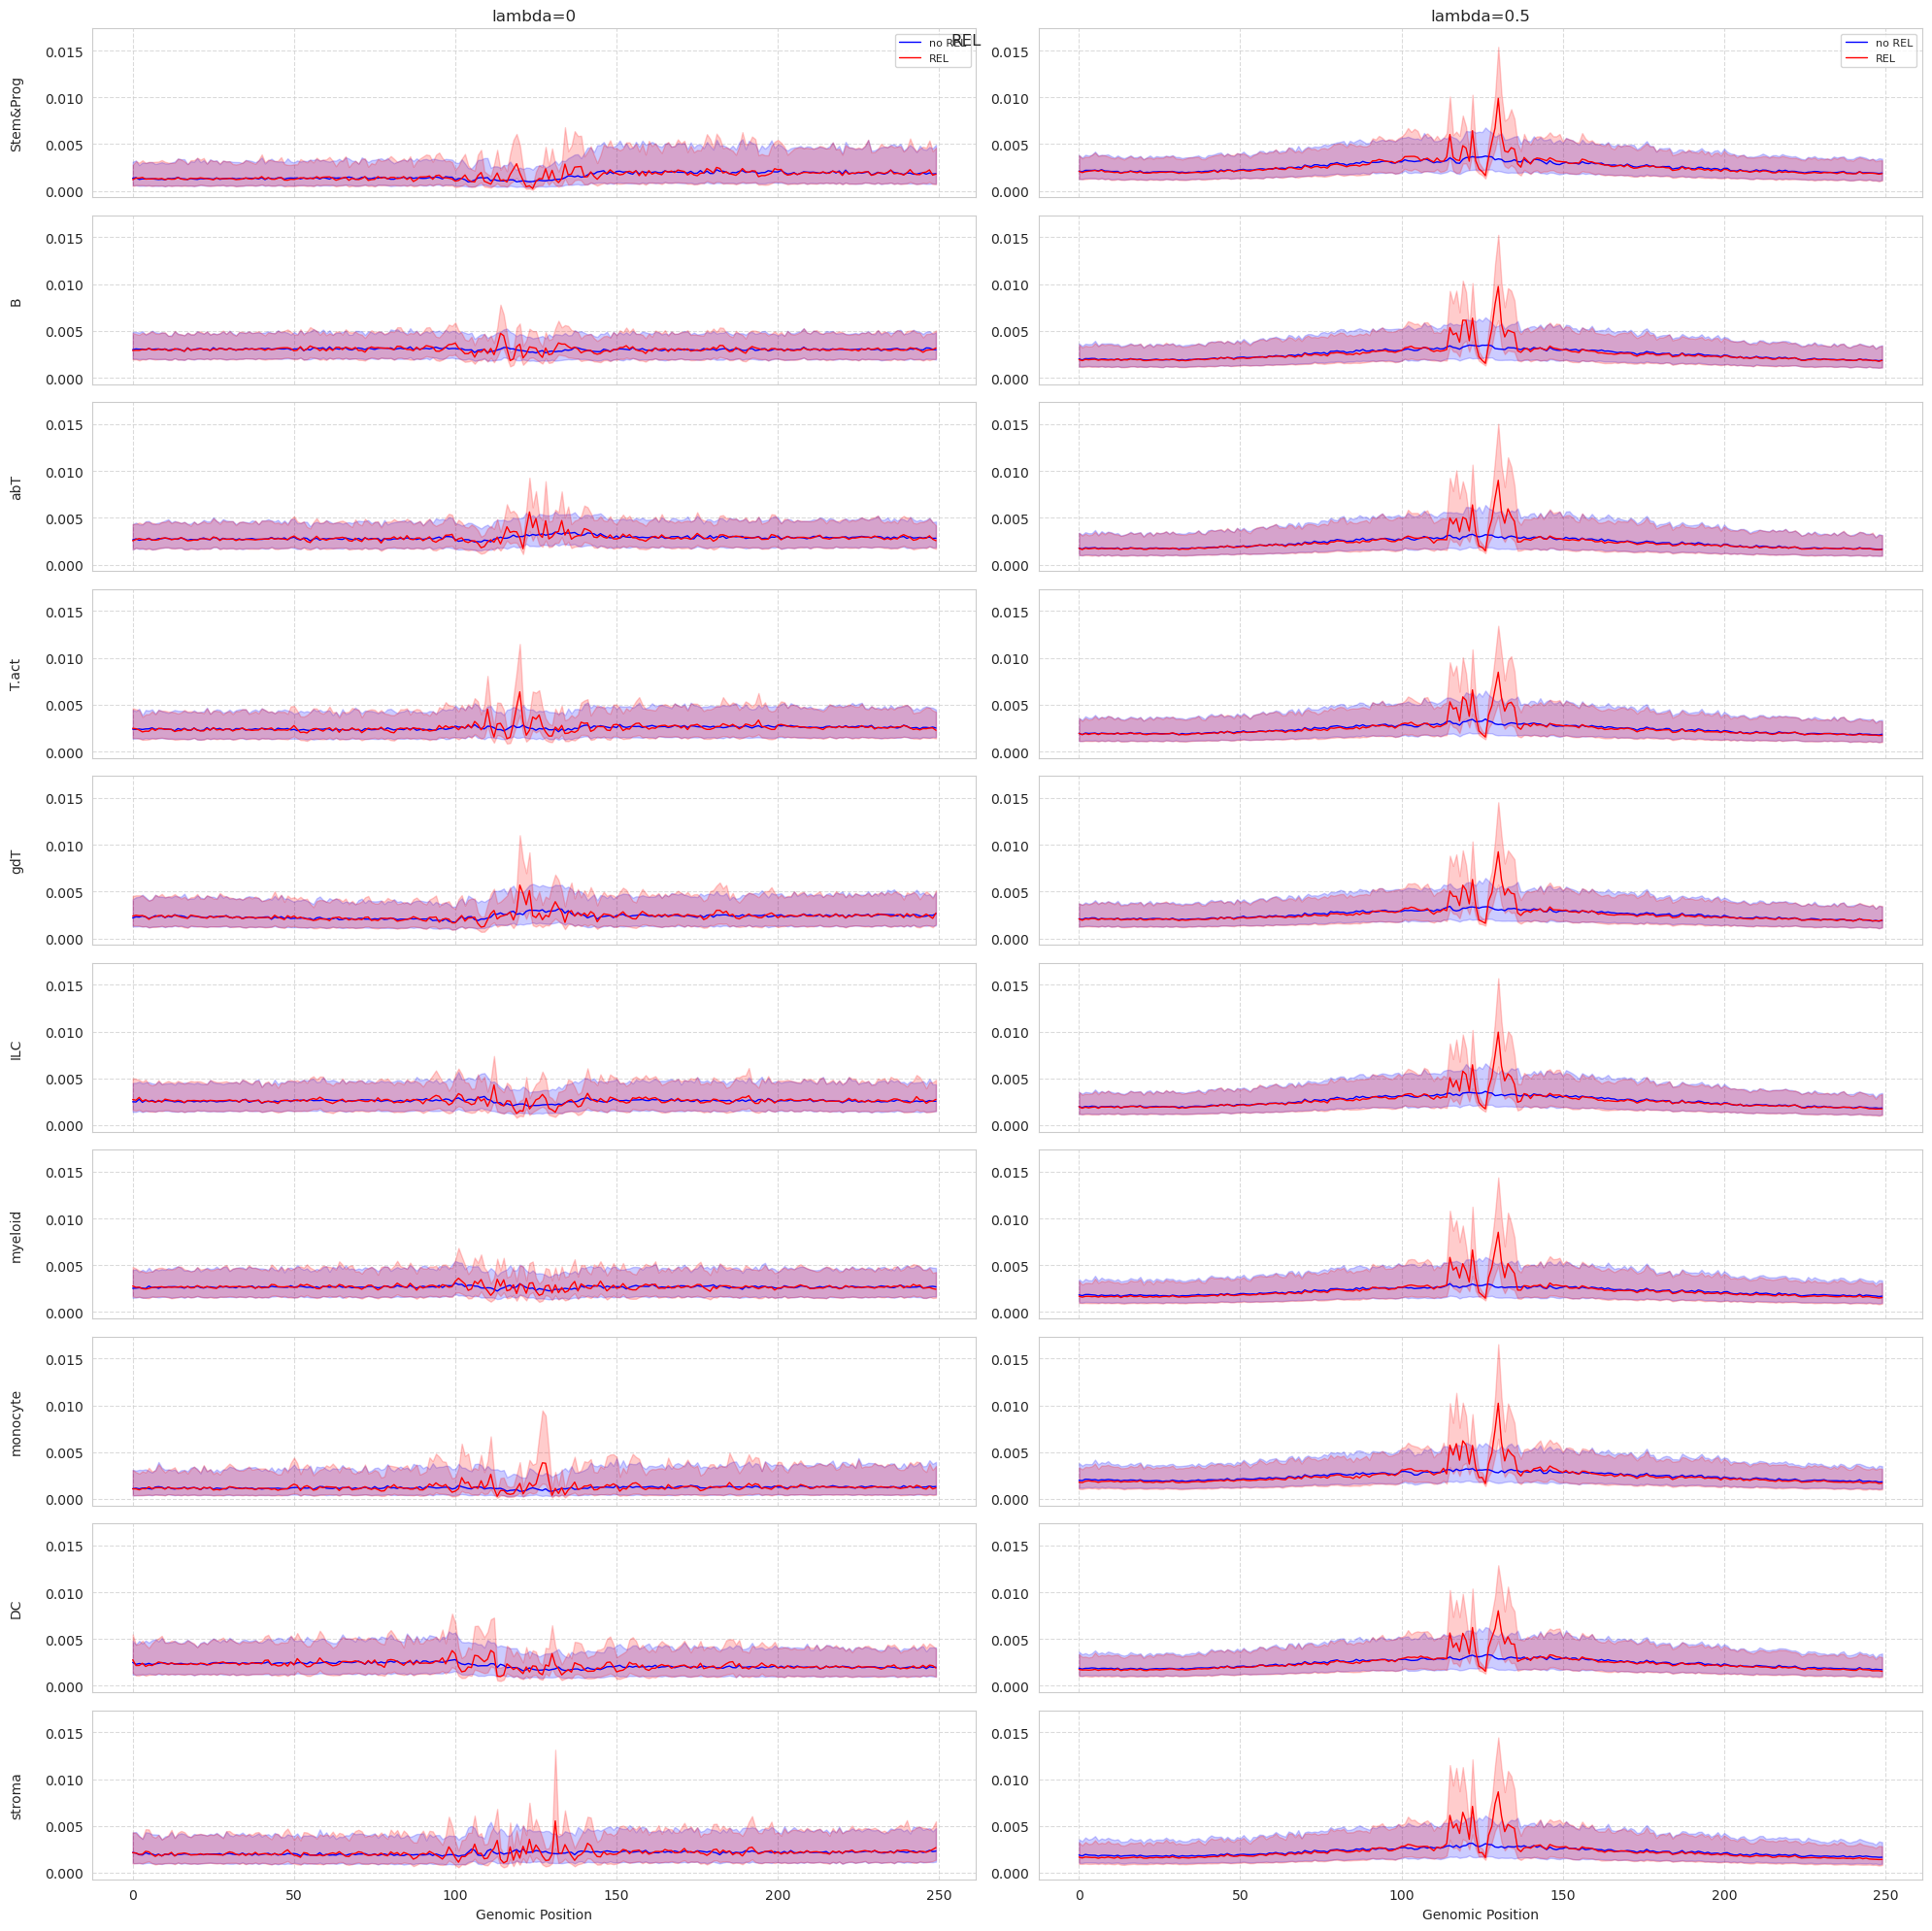

In [ ]:
fig, axes = plot_genomic_predictions_comparison(y_before_0, y_after_0, y_before_p5, y_after_p5, 
                                      lineage_names, motif_name, titles=("lambda=0", "lambda=0.5"), start_idx=375, end_idx=625, 
                                      figsize=(20, 20),
                                      band_type='quartile')
fig.suptitle(f'{motif_name}')  
fig.savefig(f'test_{model_num}_l05_{motif_name}_quartile.png')
fig.savefig(f'{save_dir}/L0vsp5_sd_{motif_name}_quartile.png')

In [ ]:
fig, axes = plot_genomic_predictions_comparison_old(
    y_before_0, y_after_0, y_before_p5, y_after_p5, 
    lineage_names,
    motif_name=motif_name,
    titles=("Lambda=0", "Lambda=0.5"),
    start_idx=375,
    end_idx=625
)
plt.show()
fig.suptitle(f'{motif_name}')  
fig.savefig('test_126_l05.png')
fig.savefig(f'{save_dir}/L0vsp5_{motif_name}.png')

NameError: name 'plot_genomic_predictions_comparison_old' is not defined

In [ ]:
# fig, axes = plot_genomic_predictions_comparison_old(
#     y_before_p5, y_after_p5, y_before_1, y_after_1, 
#     lineage_names,
#     motif_name=motif_name,
#     titles=("Lambda=0.5", "Lambda=1"),
#     start_idx=0,
#     end_idx=250
# )
# plt.show()
# fig.suptitle(f'{motif_name}')  
# fig.savefig('test_126_l51.png')
# fig.savefig(f'{save_dir}/Lp5vs1_{motif_name}.png')

# Marginalized boxplots
Make a figure of boxplots comparing lambda=0.5 and lambda=0 on a given Motif on the marginalized sequences

In [ ]:
n_examples = 1000
version_num=3
motif_name = "REL"
motif = REL
model_num = "BP126"
save_dir_name = f'{model_num}_analysis'

info_file = '/data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/info.txt'

# WE CAN JUST USE ZERO BIAS shape (N, 1, 998)



Also get dinucleotide shuffled sequences and try inserting into them.

What sequences do we start with? Let's just try loading sequences from the test dataset, selecting a random 1000, and then doing dinucleotide shuffle on them

In [ ]:
# Marginalization
save_dir = f'/data/nchand/analysis/BPcm/{save_dir_name}/testing_lineage_v{version_num}'
save_file_p5 = os.path.join(save_dir, f'{model_num}_{motif_name}_p5.npz')

file_name = f'lp5_30000_marginalization_{motif_name}after_insertion_seqfromselectedBACs_gt6avgcount_N500000bp1200_countsonhg38selectedBACs_onehot_ACGT_alignleft-cv10-0-n1outb_lfJSDnk200l25TkfGELUbp1re_dc5i1d2-4-8-16-32s1l5r11-1FSoftmaxtr0.001Adambs256-F_embedding-1.npz'

save_file_p5 = os.path.join(save_dir, f'{model_num}_{motif_name}_p5.npz')
save_file_p0 = os.path.join(save_dir, f'{model_num}_{motif_name}_p0.npz')
marg_0 = np.load(save_file_p0)
marg_p5 = np.load(save_file_p5)

# marg_0 = np.load(f'/data/nchand/analysis/BPcm/BP68_analysis/testing_lineage_v3/l0_{n_sequences}_marginalization_{motif_name}.npz')
y_before_0, y_after_0 = marg_0['y_before'], marg_0['y_after']
# marg_p5 = np.load(f'/data/nchand/analysis/BPcm/BP68_analysis/testing_lineage_v3/lp5_{n_sequences}_marginalization_{motif_name}.npz')
y_before_p5, y_after_p5 = marg_p5['y_before'], marg_p5['y_after'] 
before_insertion_seq, after_insertion_seq = marg_0['before_insertion_seq'], marg_0['after_insertion_seq']


In [ ]:
# model predictions
# f = np.load(os.path.join(bias_dir, file_name))
bias = np.zeros(shape=(len(y_before_p5),1,998))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lineage_model1 = lineage_model1.to(device)
lineage_model2 = lineage_model2.to(device)

scalar_preds_0 = get_scalar_preds(lineage_model1, n_examples, onehot_seq=after_insertion_seq, bias=bias)
scalar_preds_p5 = get_scalar_preds(lineage_model2, n_examples, onehot_seq=after_insertion_seq, bias=bias)

X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
[[0.00084717 0.00039705 0.00165896 ... 0.00751386 0.01119609 0.00139288]
 [0.00260805 0.0067344  0.00669408 ... 0.00167044 0.00470199 0.01247789]
 [0.00432165 0.00409346 0.00146006 ... 0.00316964 0.00606495 0.00109536]
 ...
 [0.00581273 0.00050023 0.00047038 ... 0.00180034 0.00149294 0.00422534]
 [0.00045105 0.00095427 0.00217649 ... 0.01301509 0.00046314 0.00214793]
 [0.00083951 0.0073353  0.00136378 ... 0.00028681 0.00064594 0.00435248]]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
[[1.1251282e-02 4.9250042e-03 2.7053748e-04 ... 5.7707576e-04
  1.7678648e-03 2.6549603e-04]
 [4.6892753e-03 4.4160937e-03 2.8557202e-03 ... 5.2104150e-03
  1.3022603e-03 6.3537280e-03]
 [3.2380703e-03 2.8418100e-03 1.7235548e-03 ... 3.4092490e-03
  1.8674367e-03 8.0908192e-03]
 ...
 [1.7200824e-04 6.8363850e-05 1.2546479e-03 ... 6.8266015e-04
  2.9268450e-04 1.7367745e-03]
 [1.5909821e-02 9.7581837e-

[[8.8328779e-05 1.4337501e-03 3.7873454e-02 ... 1.2748091e-02
  1.1735885e-02 3.5593321e-04]
 [4.1405028e-03 1.2717041e-02 2.1068545e-03 ... 1.8955285e-03
  3.2529070e-03 1.8112556e-03]
 [1.7949907e-03 1.6897644e-03 5.3189127e-03 ... 2.0286618e-03
  2.3742553e-03 4.1796253e-03]
 ...
 [1.3679167e-04 1.9686669e-04 4.7469046e-03 ... 4.8877671e-02
  4.6497276e-03 9.1629416e-05]
 [7.6756807e-04 1.6287297e-03 5.6563779e-03 ... 1.9198975e-02
  1.1851618e-03 7.2067580e-03]
 [4.5689495e-04 1.3032396e-03 1.0315090e-03 ... 2.9606230e-03
  1.9885830e-03 3.0564694e-03]]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
[[0.00036624 0.00057959 0.00508476 ... 0.00036306 0.00472646 0.00319444]
 [0.00474794 0.00355316 0.00131619 ... 0.01986411 0.00343902 0.00589248]
 [0.00441134 0.00619807 0.00389612 ... 0.00098654 0.002579   0.00404891]
 ...
 [0.00046815 0.00026709 0.00139311 ... 0.0002712  0.00330866 0.00077832]
 [0.00121924 0.00191507 0.01295782 ... 0.0028081  0.00056299 0.

## Make predictions on dinucleotide shuffled sequences

In [ ]:
from utils import load_names, load_observed

onehot_seq = load_observed(info_file=info_file, dataset_type='test', data_name='onehot')

file name /data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/complete_bias_corrected_normalized_3.7.23/memmap/test.onehot.dat


In [ ]:
from tangermeme.ersatz import dinucleotide_shuffle
from tangermeme.utils import one_hot_encode

seed = 42
np.random.seed(seed)

n_random_samples = 1000

print(onehot_seq.shape)
# grab a random 1000 sequences to do analysis with
random_indices = np.random.choice(len(onehot_seq), size=n_random_samples, replace=False)
selected_seqs = onehot_seq[random_indices]

# move our onehot_sequences to be in the shape expected by tangermeme
selected_onehot_tangermeme_format = torch.from_numpy(np.transpose(selected_seqs, (0, 2, 1)))
print('onehot tangermeme format shape', selected_onehot_tangermeme_format.shape)

onehot_shuf = dinucleotide_shuffle(selected_onehot_tangermeme_format, n=1, random_state=seed)
onehot_shuf = torch.squeeze(onehot_shuf)

(32361, 998, 4)
onehot tangermeme format shape torch.Size([1000, 4, 998])


In [ ]:
onehot_shuf.shape

torch.Size([1000, 4, 998])

In [ ]:
from tangermeme.ersatz import substitute

# insert sequences
dino_inserted = substitute(onehot_shuf, motif=motif)
dino_without_motif = onehot_shuf

# make predictions
bias = np.zeros(shape=(n_random_samples,1,998))
dino_scalar_preds_0 = get_scalar_preds(lineage_model1, n_random_samples, onehot_seq=dino_inserted, bias=bias)
dino_scalar_preds_without_motif_p0 = get_scalar_preds(lineage_model1, n_random_samples, onehot_seq=dino_without_motif, bias=bias)

dino_scalar_preds_p5 = get_scalar_preds(lineage_model2, n_random_samples, onehot_seq=dino_inserted, bias=bias)
dino_scalar_preds_without_motif_p5 = get_scalar_preds(lineage_model2, n_random_samples, onehot_seq=dino_without_motif, bias=bias)



X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
[[0.00041945 0.00091893 0.00141781 ... 0.00011143 0.00163087 0.00071627]
 [0.00699013 0.00147888 0.00888141 ... 0.00373895 0.00381182 0.02463882]
 [0.00092274 0.00191808 0.00668345 ... 0.0062221  0.00607648 0.00191086]
 ...
 [0.00122667 0.00079109 0.00056051 ... 0.00572219 0.0006249  0.01423751]
 [0.00313102 0.00258439 0.00097568 ... 0.00074558 0.01372077 0.0023343 ]
 [0.00152141 0.00495175 0.00399901 ... 0.00336041 0.00128517 0.00147602]]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
[[2.0775618e-03 4.4686184e-04 5.7362625e-03 ... 7.4079190e-04
  1.3203122e-02 4.5929621e-03]
 [1.8350790e-03 1.0255842e-03 2.2590489e-03 ... 5.4184548e-03
  6.3389880e-03 3.1788524e-03]
 [3.0036056e-03 3.6506273e-03 1.6400124e-03 ... 1.2080501e-03
  2.9013248e-03 3.6380864e-03]
 ...
 [5.1251533e-03 1.3974243e-02 2.0221316e-05 ... 7.3774462e-04
  1.4663419e-02 5.1643455e-04]
 [1.5060793e-03 2.0289221e-

[[8.3589944e-04 4.1352567e-04 4.4382229e-03 ... 1.3088372e-03
  9.7032724e-04 2.4635193e-03]
 [3.0331856e-03 1.1712250e-03 3.8366835e-03 ... 6.7245733e-04
  2.2037106e-03 2.0360199e-03]
 [1.3487006e-03 2.9985455e-03 1.3524389e-02 ... 4.0490776e-03
  4.3504536e-03 1.4385477e-03]
 ...
 [1.6908538e-04 1.1173113e-03 6.5877321e-05 ... 3.7443612e-03
  3.5322693e-04 4.3461888e-04]
 [1.8566877e-03 5.5515155e-04 4.8437496e-03 ... 1.0800346e-03
  8.0920244e-04 1.7879641e-02]
 [4.7191544e-03 5.5059306e-03 1.4888154e-03 ... 8.5933314e-04
  9.1991480e-04 5.5427132e-03]]
X shape torch.Size([1, 4, 998])
bias shape in get pred torch.Size([1, 998])
[[0.003061   0.0003135  0.0017551  ... 0.00291178 0.00650177 0.0048947 ]
 [0.01120671 0.00364091 0.00329705 ... 0.00386498 0.0039697  0.00206017]
 [0.00458494 0.00449283 0.00191058 ... 0.00185634 0.00419414 0.00237594]
 ...
 [0.00151779 0.01006278 0.00049108 ... 0.00787875 0.0045404  0.00149093]
 [0.00898632 0.00166476 0.00219272 ... 0.00031256 0.00157157 0.

In [ ]:
import seaborn as sns

def create_comparison_boxplot(preds_model1, preds_model2, cellnames, motif_name, 
                            figsize=(15, 6), title="", show_outliers=True):
    # Create a dataframe in long format
    data_list = []
    
    # For each celltype
    for i in range(10):
        # Add data for model1
        data_list.extend([{
            'Celltype': f'{cellnames[i]}',
            'Model': 'ʎ=0',
            'Prediction': val
        } for val in preds_model1[:, i]])
        
        # Add data for model2
        data_list.extend([{
            'Celltype': f'{cellnames[i]}',
            'Model': 'ʎ=0.5',
            'Prediction': val
        } for val in preds_model2[:, i]])
    
    df = pd.DataFrame(data_list)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create boxplot using seaborn with optional outliers
    sns.boxplot(data=df, x='Celltype', y='Prediction', 
                hue='Model', palette=['lightblue', 'orange'],
                showfliers=show_outliers)
    
    # Customize the plot
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Cell Type')
    plt.ylabel('Prediction Value')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt


def create_difference_boxplot(preds_model1, preds_model2, cellnames, motif_name, 
                            figsize=(15, 6), title=""):
    # Create a dataframe in long format
    data_list = []
    
    # For each celltype
    for i in range(10):
        # Calculate and store differences (model2 - model1)
        data_list.extend([{
            'Celltype': f'{cellnames[i]}',
            'Difference': val2 - val1
        } for val1, val2 in zip(preds_model1[:, i], preds_model2[:, i])])
    
    df = pd.DataFrame(data_list)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create boxplot using seaborn
    sns.boxplot(data=df, x='Celltype', y='Difference', color='lightgreen')
    
    # Add horizontal line at y=0 to show baseline (no difference)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Customize the plot
    plt.xticks(rotation=45)
    plt.title(title if title else f'Prediction Differences (ʎ=0.5 - ʎ=0)\n{motif_name}')
    plt.xlabel('Cell Type')
    plt.ylabel('Prediction Difference')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt


In [ ]:
sc_5 = np.mean(scalar_preds_p5, axis=0)
sc_0 = np.mean(scalar_preds_0, axis=0)

NameError: name 'scalar_preds_p5' is not defined

In [ ]:
print(sc_5)
print(sc_0)
plt.clf()

[ 6.98710277 30.21441206 29.36643357 35.45254069 24.72575656 39.43483238
 49.10362325 53.08341088 46.89660728 65.29853661]
[11.25959995 44.81890012 45.21832049 51.20695229 36.570937   48.27517689
 73.84012585 74.0293261  61.90828283 55.49759116]


<Figure size 640x480 with 0 Axes>

In [ ]:
from tqdm import tqdm
def predict_all(model, onehot_seq, out_seq_len=998, n_celltypes=90, batch_size=100, device='cuda'):
    """
    onehot_seq has shape (n, 4, seq_len)
    assumes zero bias
    """
    torch.cuda.empty_cache()
    model.to(device)
    counts = torch.zeros((0, n_celltypes)).to(device)
    profile_pred = torch.zeros((0, n_celltypes, out_seq_len)).to(device)

    if torch.is_tensor(onehot_seq):
        seq = onehot_seq
    else:
        seq = torch.from_numpy(onehot_seq)
        
    # Calculate number of batches (ceiling division)
    n_batches = (len(seq) + batch_size - 1) // batch_size
    
    # Process all batches including the final partial batch
    for i in tqdm(range(n_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(seq))
        X = seq[start_idx:end_idx]
        bias = torch.zeros((X.shape[0], X.shape[2]))
        with torch.no_grad():
            profile, scalar = model(X.to(device), bias.to(device))
            counts = torch.cat((counts, scalar), 0)
            profile_pred = torch.cat((profile_pred, profile), 0)
    
    return profile_pred.cpu().numpy(), counts.cpu().numpy()


In [ ]:
def get_preds_for_multiple_motifs(lineage_model1, lineage_model2, onehot_shuf, motifs):
    bias = np.zeros(shape=(n_random_samples,1,998))
    profile_out_seq_len = 250
    n_celltypes=10
    dino_without_motif = onehot_shuf

    # Create separate dictionaries for each type of prediction
    model1_with_motif_scalar = {}        # Predictions from model1 with motif
    model1_with_motif_profile = {}
    model1_without_motif_scalar = {}     # Predictions from model1 without motif
    model1_without_motif_profile = {}

    model2_with_motif_scalar = {}        # Predictions from model2 with motif
    model2_with_motif_profile = {}
    model2_without_motif_scalar = {}     # Predictions from model2 without motif
    model2_without_motif_profile = {}

    for motif in motifs:
        # Get sequence with motif inserted
        dino_inserted = substitute(onehot_shuf, motif=motif)
        
        # Get predictions for model1
        model1_with_motif_profile[motif], model1_with_motif_scalar[motif] = predict_all(lineage_model1, out_seq_len=profile_out_seq_len, onehot_seq=dino_inserted, n_celltypes=n_celltypes)
        model1_without_motif_profile[motif], model1_without_motif_scalar[motif] = predict_all(lineage_model1, out_seq_len=profile_out_seq_len, onehot_seq=dino_without_motif, n_celltypes=n_celltypes)

        # Get predictions for model2
        model2_with_motif_profile[motif], model2_with_motif_scalar[motif] = predict_all(lineage_model2, out_seq_len=profile_out_seq_len, onehot_seq=dino_inserted, n_celltypes=n_celltypes)
        model2_without_motif_profile[motif], model2_without_motif_scalar[motif] = predict_all(lineage_model2, out_seq_len=profile_out_seq_len, onehot_seq=dino_without_motif, n_celltypes=n_celltypes)

    return {
        'model1_with_motif': model1_with_motif_scalar,
        'model1_without_motif': model1_without_motif_scalar,
        'model2_with_motif': model2_with_motif_scalar,
        'model2_without_motif': model2_without_motif_scalar
    },{
        'model1_with_motif': model1_with_motif_profile,
        'model1_without_motif': model1_without_motif_profile,
        'model2_with_motif': model2_with_motif_profile,
        'model2_without_motif': model2_without_motif_profile
    }

def calculate_differences(predictions, motifs):
    """
    Calculate differences between predictions with and without motifs for both models
    
    Args:
        predictions: Dictionary containing all predictions from get_preds_for_multiple_motifs
        motifs: List of motifs used in predictions
    
    Returns:
        difference_model1: Dictionary of differences for model1
        difference_model2: Dictionary of differences for model2
    """
    difference_model1 = {}
    difference_model2 = {}
    
    for motif in motifs:
        # Calculate difference for model1
        difference_model1[motif] = (
            predictions['model1_with_motif'][motif] - predictions['model1_without_motif'][motif]
        )
        
        # Calculate difference for model2
        difference_model2[motif] = (
            predictions['model2_with_motif'][motif] - predictions['model2_without_motif'][motif]
        )
    
    return difference_model1, difference_model2

# def pred_on_seq_for_multiple_motifs(lineage_model1, lineage_model2, onehot_shuf, motifs):
#     bias = np.zeros(shape=(n_random_samples,1,998))
#     dino_without_motif = onehot_shuf

#     difference_model1 = {}
#     difference_model2 = {}

#     for motif in motifs:
#         dino_inserted = substitute(onehot_shuf, motif=motif)
        
#         dino_scalar_preds_0 = get_scalar_preds(lineage_model1, n_random_samples, onehot_seq=dino_inserted, bias=bias)
#         dino_scalar_preds_without_motif_p0 = get_scalar_preds(lineage_model1, n_random_samples, onehot_seq=dino_without_motif, bias=bias)

#         dino_scalar_preds_p5 = get_scalar_preds(lineage_model2, n_random_samples, onehot_seq=dino_inserted, bias=bias)
#         dino_scalar_preds_without_motif_p5 = get_scalar_preds(lineage_model2, n_random_samples, onehot_seq=dino_without_motif, bias=bias)
        
#         difference_model1[motif] = dino_scalar_preds_0 - dino_scalar_preds_without_motif_p0 
#         difference_model2[motif] = dino_scalar_preds_p5 - dino_scalar_preds_without_motif_p5

#     return difference_model1, difference_model2

motifs = [REL, PTF1A, MOTIF_53]
scalar_predictions, profile_predictions = get_preds_for_multiple_motifs(lineage_model1, lineage_model2, onehot_shuf, motifs=motifs)
p0_diff, p5_diff = calculate_differences(scalar_predictions, motifs)

# p0_diff, p5_diff = pred_on_seq_for_multiple_motifs(lineage_model1, lineage_model2, onehot_shuf, motifs=motifs)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


In [ ]:
def create_stacked_comparison_boxplots(predictions_list, cellnames, motif_names,
                                     figsize=(15, 6), show_outliers=True):
    """
    Create multiple boxplots stacked vertically comparing predictions between two models.
    Adds significance stars based on p-values:
    * : p < 0.05
    ** : p < 0.01
    *** : p < 0.001
    
    Parameters:
    -----------
    predictions_list : list of tuples
        List of (preds_model1, preds_model2) tuples for each motif/feature
    cellnames : list
        List of cell type names
    motif_names : list
        List of motif/feature names
    figsize : tuple, optional
        Base figure size that will be adjusted based on number of plots
    show_outliers : bool, optional
        Whether to show outliers in the boxplots
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure containing all subplots
    """
    from scipy import stats
    num_plots = len(predictions_list)
    
    # Adjust figure height based on number of plots
    adjusted_figsize = (figsize[0], figsize[1] * num_plots)
    
    # Create figure and subplots
    fig, axes = plt.subplots(num_plots, 1, figsize=adjusted_figsize)
    if num_plots == 1:
        axes = [axes]
    
    # For each motif/feature
    for idx, ((preds_model1, preds_model2), motif_name, ax) in enumerate(zip(predictions_list, motif_names, axes)):
        data_list = []
        
        # For each celltype
        for i in range(len(cellnames)):
            # Add data for model1
            data_list.extend([{
                'Celltype': f'{cellnames[i]}',
                'Model': 'ʎ=0',
                'Prediction': val
            } for val in preds_model1[:, i]])
            
            # Add data for model2
            data_list.extend([{
                'Celltype': f'{cellnames[i]}',
                'Model': 'ʎ=0.5',
                'Prediction': val
            } for val in preds_model2[:, i]])
        
        df = pd.DataFrame(data_list)
        
        # Create boxplot on current subplot
        sns.boxplot(data=df, x='Celltype', y='Prediction',
                   hue='Model', palette=['lightblue', 'orange'],
                   showfliers=show_outliers, ax=ax)
        
        # Add significance stars
        for i, celltype in enumerate(cellnames):
            # Get data for current celltype from both models
            model1_data = preds_model1[:, i]
            model2_data = preds_model2[:, i]
            
            # Perform Mann-Whitney U test
            statistic, pvalue = stats.mannwhitneyu(model1_data, model2_data, 
                                                 alternative='two-sided')
            
            # Determine number of stars based on p-value
            stars = ''
            if pvalue < 0.001:
                stars = '***'
            elif pvalue < 0.01:
                stars = '**'
            elif pvalue < 0.05:
                stars = '*'
            
            # If significant, add stars
            if stars:
                # Get y coordinates for the boxes
                box_data = [model1_data, model2_data]
                max_val = max(np.percentile(model1_data, 75), 
                            np.percentile(model2_data, 75))
                
                # Add stars slightly above the higher box
                y_pos = max_val + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
                x_pos = i
                ax.text(x_pos, y_pos, stars, ha='center', va='bottom', 
                       fontsize=12, fontweight='bold')
        
        # Customize the subplot
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_xlabel('Cell Type' if idx == num_plots-1 else '')
        ax.set_ylabel(motif_name)
        
        # Adjust legend position
        if idx < num_plots:  # Remove legend for all but the last plot
            ax.get_legend().remove()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

In [ ]:
# Create the predictions list for plotting
predictions_list = [
    (p0_diff[motif], p5_diff[motif])
    for motif in motifs
]

motif_names = ['REL', 'PTF1A', 'MOTIF 53']

# Create the plot
fig = create_stacked_comparison_boxplots(
    predictions_list=predictions_list,
    cellnames=lineage_names,  # Your list of cell type names
    motif_names=motif_names,   # Your list of motif names
    figsize=(12, 1),
    show_outliers=False
)

fig.savefig('test_stacked.png', bbox_inches='tight', dpi=330)


NameError: name 'create_stacked_comparison_boxplots' is not defined

In [ ]:
# get the two models predictions on the data for 3 different motifs 
dino_inserted_REL = substitute(onehot_shuf, motif=REL)
dino_inserted_PTF1A = substitute(onehot_shuf, motif=PTF1A)
dino_inserted_53 = substitute(onehot_shuf, motif=MOTIF_53)
dino_without_motif = onehot_shuf

/tmp/ipykernel_1390660/1254717036.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


saved at /data/nchand/analysis/BPcm/BP126_analysis/testing_lineage_v3/diff_comparsion_dino_BP126_REL


<Figure size 640x480 with 0 Axes>

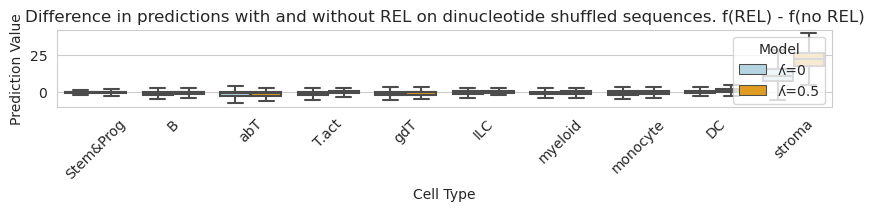

In [ ]:
# boxplot = create_comparison_boxplot(dino_scalar_preds_0, dino_scalar_preds_p5, cellnames=lineage_names, motif_name=motif_name, title=f'Accessibility predictions on dinucleotide shuffled sequences with {motif_name}', show_outliers=False)
# plt.show()

plt.clf()

motif_diff_p0 = dino_scalar_preds_0 - dino_scalar_preds_without_motif_p0
motif_diff_p5 = dino_scalar_preds_p5 - dino_scalar_preds_without_motif_p5
fig_size= (10,1)
diff_comparison_boxplot = create_comparison_boxplot(motif_diff_p0, motif_diff_p5, cellnames=lineage_names, motif_name=motif_name, title=f'Difference in predictions with and without {motif_name} on dinucleotide shuffled sequences. f({motif_name}) - f(no {motif_name})', show_outliers=False, figsize=fig_size)
save_filename = f'diff_comparsion_dino_{model_num}_{motif_name}'
plt.savefig(os.path.join(save_dir, save_filename))
print('saved at', os.path.join(save_dir, save_filename))
plt.show()



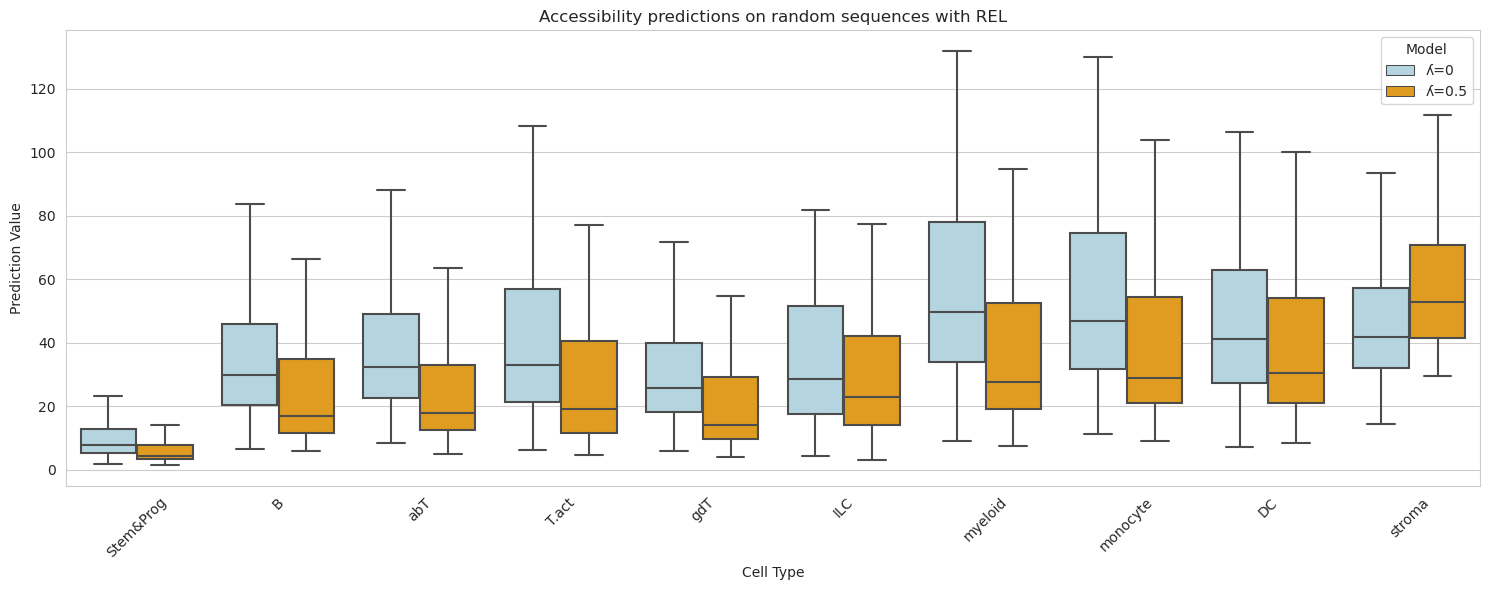

In [ ]:
boxplot = create_comparison_boxplot(scalar_preds_0, scalar_preds_p5, cellnames=lineage_names, motif_name=motif_name, title=f'Accessibility predictions on random sequences with {motif_name}', show_outliers=False)

plt.show()

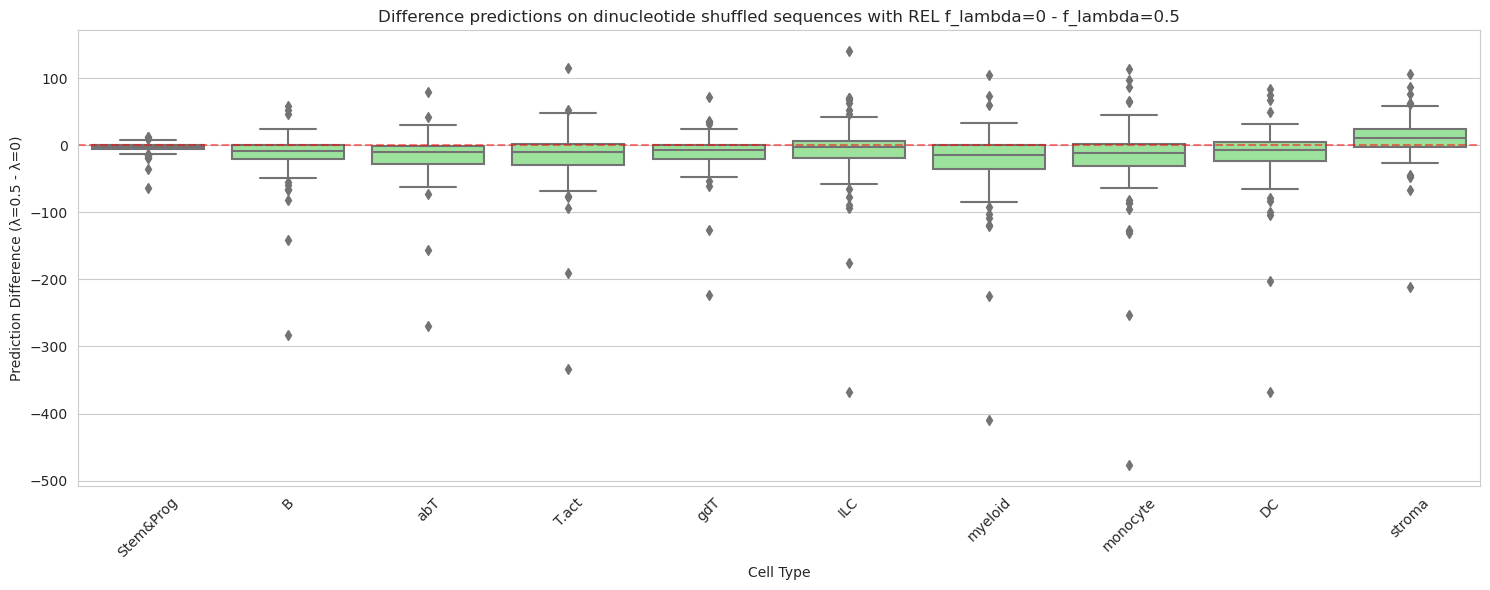

In [ ]:
boxplot = create_difference_boxplot(preds_model1=scalar_preds_0, preds_model2=scalar_preds_p5, cellnames=lineage_names, motif_name=motif_name, title=f'Difference predictions on dinucleotide shuffled sequences with {motif_name} f_lambda=0 - f_lambda=0.5')
plt.show()

# Figure 3c  and 3d


## Show footprint for selected motifs that we made boxplots for

Get the footprint predictions for REL, PTF1A and Cluster 53 as well

In [ ]:
# get the bp predictions?
profile_predictions
profile_predictions['model1_without_motif']

# get just stroma cell predictions for all motifs 
# what index is stroma cell

cell_idx = 9 # where(lineage_names == 'stroma')
print('Cell idx is', cell_idx)
model_motif_combos = ['model1_without_motif', 'model1_with_motif', 'model2_without_motif', 'model2_with_motif']
stroma_predictions = {}
for combo in model_motif_combos:
    stroma_array = np.zeros((n_random_samples, len(motifs), 250))
    combo_data = profile_predictions[combo]
    for i, motif in enumerate(combo_data):
        # grab only the stroma cells 
        stroma_array[:, i, :] = combo_data[motif][:, cell_idx, :]
    stroma_predictions[combo] = stroma_array

print(stroma_predictions['model1_without_motif'].shape)


Cell idx is 9
(1000, 3, 250)


yb mean, and yb upper (3, 250) (3, 250)
[0.0020129  0.0019094  0.00204921 ... 0.00144726 0.00140636 0.0013906 ]


/tmp/ipykernel_68258/3990351724.py:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 0].set_xticklabels(relative_ticks)
/tmp/ipykernel_68258/3990351724.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, 1].set_xticklabels(relative_ticks)


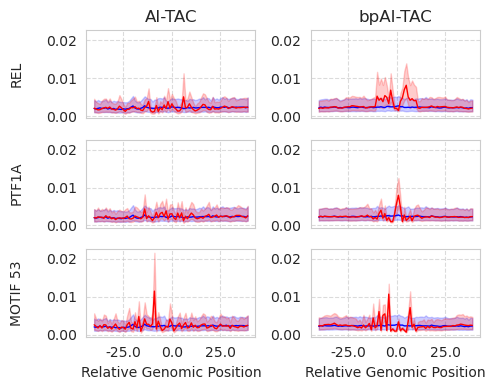

In [ ]:
fig, axes = plot_genomic_predictions_comparison(y_before1=stroma_predictions['model1_without_motif'],
                                    y_after1=stroma_predictions['model1_with_motif'],
                                    y_before2=stroma_predictions['model2_without_motif'],
                                    y_after2=stroma_predictions['model2_with_motif'],
                                    lineage_names=motif_names,
                                    motif_name=None,
                                    band_type='quartile',
                                    titles=("AI-TAC", "bpAI-TAC"), start_idx=85, end_idx=165, figsize=(5, 4),
                                    relative_position_labels=True)
fig.savefig('final_figs/3d_footprints_zoom.png', dpi=330)


Check that single lineage model worked

# Check that single lineage model worked

In [ ]:
n_celltypes = 1
lineage_names = ["DC"]
motif= REL
motif_name = "REL"

# TODO change path to model
path_model='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP148_L-1_5/complete/01-01-2025.16.20/best_model'
info_file='/data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/lineage_DC_complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/info.txt'
# path_model='/homes/gws/nchand/MostafaviLab/results/BPcm_250/BP150_L-1_5/complete/12-31-2024.10.45/best_model'
# info_file='/data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/lineage_B_complete_bias_corrected_normalized_12.30.24/memmap/info.txt'

model= load_model(path_model, model_structure=get_model_structure('BPcm_250', 300, n_celltypes, seq_len=seq_len), n_filters=300, verbose=False)
wrapped_model = AttributionModelWrapper(model)

onehot = load_observed(info_file, 'train', 'onehot')
bias = load_observed(info_file, 'train', 'bias')
total_counts = load_observed(info_file, 'train', 'total_counts')
index = np.argmax(total_counts)
print(index)
# bias = np.zeros(shape=(n_random_samples,1,998))
profile, scalar = get_pred(model, onehot[index].transpose(1, 0), bias[index])


199
39
7
DEVICE is cuda:3
998 300 90


/homes/gws/nchand/MostafaviLab/bpAITAC/load_model.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


FileNotFoundError: [Errno 2] No such file or directory: '/data/nchand/ImmGen/mouse/BPprofiles1000/memmaped/lineage_DC_complete_shallow_deprotinated_bias_quantile_normalized_4.1.25/memmap/info.txt'

In [ ]:
y_before, y_after = get_marginalized(X, model, motif)

torch.Size([1000, 4, 998])
y before and after shape torch.Size([1000, 1, 250]) torch.Size([1000, 1, 250])


In [ ]:
motif_name

'REL'

In [ ]:
y_before.shape

torch.Size([1000, 1, 250])

median shape (1, 250)
median shape (1, 250)
(1, 250)
[[0.00174889 0.00175129 0.00183592 0.00173956 0.00184054 0.00177226
  0.001742   0.00184328 0.00171248 0.00181677 0.00176469 0.00165686
  0.00172345 0.00169351 0.00161576 0.00168349 0.00175164 0.00174048
  0.00170731 0.00171167 0.00162699 0.00169883 0.001748   0.00167123
  0.00177582 0.00165128 0.00181094 0.00168748 0.00170803 0.00192521
  0.00166478 0.0018686  0.00173577 0.00175304 0.0019378  0.00169361
  0.00186098 0.00179458 0.00172844 0.00186553 0.00180865 0.00192956
  0.0017804  0.00188288 0.0019245  0.0019831  0.00195501 0.00202136
  0.0021032  0.0020847  0.00213085 0.00202191 0.00206506 0.00222296
  0.00212857 0.00216143 0.00212447 0.00209113 0.00219864 0.00220828
  0.0023042  0.00234566 0.0023573  0.00229797 0.00217897 0.00229493
  0.0022628  0.00235949 0.00230721 0.00243516 0.00249335 0.00227518
  0.00239686 0.00224599 0.00242912 0.00238547 0.00237965 0.00230467
  0.00227721 0.00254648 0.00244526 0.00242283 0.0023979  0.0024

(<Figure size 1000x200 with 1 Axes>,
 [<AxesSubplot:title={'center':'Genomic Predictions'}, xlabel='Genomic Position', ylabel='DC\n'>])

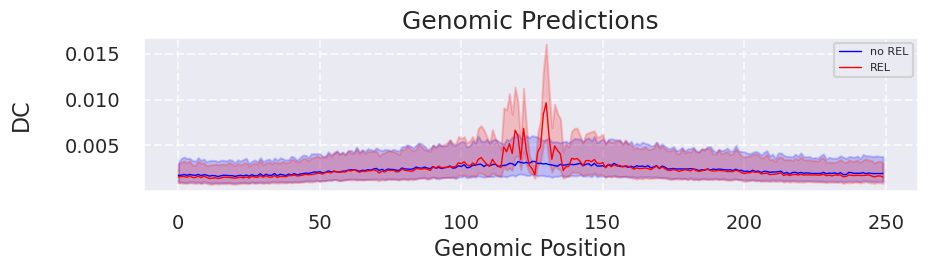

In [ ]:

plot_genomic_predictions(y_before, y_after, lineage_names, motif_name, 
                             title="Genomic Predictions", start_idx=375, end_idx=625, 
                             figsize=(10, 2), band_type="quartile")